In [48]:
#scan.ipynb
#by Joe Hahn, jmh.datasciences@gmail.com, 2 August 2020.
#inspect the output of all simulations launched by scan.py that executed in 36 hours

In [49]:
#monitor execution time
import time as tm
t_start = tm.time()

In [50]:
#get paths to all simulations
import os
parent_path = 'permutations/'
paths = os.listdir(parent_path)
paths.remove('nothing')
paths = [parent_path + path for path in paths]
print 'number of paths = ', len(paths)
paths[0:5]

number of paths =  324


['permutations/sim_id=155!total_ring_mass=9.999999999999985e-12!shear_viscosity=9.999999999999987e-15!bulk_viscosity=9.999999999999987e-15!radial_width=0.0002!timesteps_per_output=95!',
 'permutations/sim_id=204!total_ring_mass=3.162277660168382e-11!shear_viscosity=1.000000000000001e-12!bulk_viscosity=1.000000000000001e-12!radial_width=2.5e-05!timesteps_per_output=164!',
 'permutations/sim_id=290!total_ring_mass=1.0000000000000007e-09!shear_viscosity=1.0000000000000013e-15!bulk_viscosity=1.0000000000000013e-15!radial_width=0.0001!timesteps_per_output=510!',
 'permutations/sim_id=323!total_ring_mass=1.0000000000000007e-09!shear_viscosity=9.999999999999985e-12!bulk_viscosity=9.999999999999985e-12!radial_width=0.0002!timesteps_per_output=211!',
 'permutations/sim_id=123!total_ring_mass=3.1622776601683786e-12!shear_viscosity=3.162277660168383e-14!bulk_viscosity=3.162277660168383e-14!radial_width=0.0002!timesteps_per_output=94!']

In [51]:
#prep plots
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 0})
color_seq = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [52]:
#order paths by sim_id
data = []
for p in paths:
    str_id = int(p.split('sim_id=')[1].split('!total_ring_mass=')[0])
    d = {'sim_id':str_id, 'path':p}
    data += [d]
paths_df = pd.DataFrame(data)[['sim_id', 'path']].sort_values('sim_id').reset_index(drop=True)
paths_df.head()

sim_id                                               path
0       0  permutations/sim_id=0!total_ring_mass=9.999999...
1       1  permutations/sim_id=1!total_ring_mass=9.999999...
2       2  permutations/sim_id=2!total_ring_mass=9.999999...
3       3  permutations/sim_id=3!total_ring_mass=9.999999...
4       4  permutations/sim_id=4!total_ring_mass=9.999999...

In [53]:
#nominal ringlet's properties
nominal_total_ring_mass = 1.0e-10
nominal_shear_viscosity = 3.3e-13
nominal_radial_width = 0.0001

In [54]:
#get outcome of every sim
plot_q = False
from helper_fns import *
from libration import *
data = []
xlim = (-0.2, 10.2)
for idx, row in paths_df.iterrows():
    
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    d = {}
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    current_timestep = monitor['current_timestep']
    streamline_crossing_timestep = monitor['streamline_crossing_timestep']
    nan_timestep = monitor['nan_timestep']
    expected_timestep = timesteps_per_output*total_number_of_outputs
    d['current_timestep'] = current_timestep
    d['streamline_crossing_timestep'] = streamline_crossing_timestep
    d['nan_timestep'] = nan_timestep
    d['expected_timestep'] = expected_timestep
    d['path'] = path

    #check if sim completed
    d['outcome'] = 'unsure'
    if ((streamline_crossing_timestep > 0) or (nan_timestep > 0)):
        d['outcome'] = 'crossed streamlines'
    if (streamline_crossing_timestep == None):
        if (nan_timestep == None):
            if (current_timestep == expected_timestep):
                d['outcome'] = 'simulation complete'
    
    #compute observed dynamical_timescale=time when q exceeds 0.6
    try:
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        jdx = (q > 0.6)
        d['dynamical_timescale'] = times[jdx][0]
        da0 = da[0]
        d['viscous_timescale'] = (da0**2)/(12.0*d['shear_viscosity'])
        if (plot_q):
            jdx = (q > 0)
            if (jdx.sum() > 0):
                xp = times[jdx]
                yp = q[jdx]
                sns.set(font_scale=1.0, font='DejaVu Sans')
                f, ax = plt.subplots(figsize=(10, 3))
                p = ax.plot(xp, yp, linestyle='-', label='q')
                yp = e_prime[jdx]
                p = ax.plot(xp, yp, linestyle='-', label="e'")
                xp = d['dynamical_timescale']
                kdx = (q > 0.6)
                yp = q[kdx][0]
                color = color_seq[3]
                p = ax.plot(xp, yp, marker='o', markersize=8, color=color, label=r'$\tau_{dyn}$')
                title = 'sim_id = ' + str(d['sim_id'])
                p = ax.set_title(title)
                p = ax.set_xlabel('times')
                p = ax.set_ylabel("q, e'")
                p = ax.set_ylim(0, 1)
                p = ax.legend()
    except:
        d['dynamical_timescale'] = np.nan
    
    #collect stats from completed sims
    if (d['outcome'] == 'simulation complete'):
        jdx = (times > 0.8*times.max())
        d['q'] = q[jdx].mean()
        d['delta_q'] = 0.5*(q[jdx].max() - q[jdx].min())
        d['dwt'] = dwt[jdx].mean()
        d['wt_prime'] = wt_prime[jdx].mean()
        d['e_prime'] = e_prime[jdx].mean()
        d['delta_q_over_q'] = d['delta_q']/d['q']
        
        #outcome=self-confining provided sim completes with q > 0.8
        if (d['q'] > 0.8):
            d['outcome'] = 'self-confining'
            e_prime_brackets = [0.0, 0.1, 0.6, 0.8]
            for e_prime_bracket in e_prime_brackets:
                if (d['e_prime'] > e_prime_bracket):
                    d['e_prime_bracket'] = e_prime_bracket
        else:
            #otherwise set dynamical_timescale=3*current_timestep
            d['dynamical_timescale'] = 3*current_timestep
            d['outcome'] = 'unconfined'
    
    data += [d]

df = pd.DataFrame(data)
print (df.outcome.value_counts())
print (df.e_prime_bracket.value_counts().sort_index(ascending=False))
df['nominal'] = False
small = 1.0e-15
df['r'] = np.abs(df.total_ring_mass - nominal_total_ring_mass + small) * \
    np.abs(df.shear_viscosity - nominal_shear_viscosity + small) * \
    np.abs(df.radial_width - nominal_radial_width + small)
idx = df.r.values.argmin()
df.loc[idx, 'nominal'] = True
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'nan_timestep', 
    'dynamical_timescale', 'viscous_timescale', 'timesteps_per_output', 'total_ring_mass', 'radial_width', 
    'shear_viscosity', 'bulk_viscosity', 'q', 'delta_q', 'delta_q_over_q', 'e_prime', 'dwt', 'wt_prime', 
    'outcome', 'e_prime_bracket', 'nominal', 'path']
df = df[cols]
df = df.sort_values('sim_id').reset_index(drop=True)
df.columns = df.columns.astype(str)
df_results = df
df_results.sample(5)

/Users/joe/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


self-confining         158
crossed streamlines    120
unconfined              46
Name: outcome, dtype: int64
0.8    42
0.6    22
0.1    40
0.0    54
Name: e_prime_bracket, dtype: int64


sim_id  expected_timestep  current_timestep  \
44       44             117000            117000   
163     163              98000             98000   
34       34             142000            142000   
220     220             510000            510000   
40       40             104000            104000   

     streamline_crossing_timestep  nan_timestep  dynamical_timescale  \
44                            NaN           NaN               5850.0   
163                           NaN           NaN               4900.0   
34                            NaN           NaN               7100.0   
220                           NaN           NaN            1530000.0   
40                            NaN           NaN               5252.0   

     viscous_timescale  timesteps_per_output  total_ring_mass  radial_width  \
44         5210.017845                   117     3.162278e-13      0.000025   
163       33338.660938                    98     1.000000e-11      0.000200   
34           83.333866                   142     1.000000e-13      0.000100   
220                NaN                   510     1.000000e-10      0.000025   
40        16475.523040                   104     3.162278e-13      0.000025   

     shear_viscosity  bulk_viscosity         q   delta_q  delta_q_over_q  \
44      1.000000e-14    1.000000e-14  0.876560  0.015947        0.018193   
163     1.000000e-13    1.000000e-13  0.834202  0.093245        0.111777   
34      1.000000e-11    1.000000e-11  0.867053  0.001074        0.001238   
220     3.162278e-15    3.162278e-15  0.022744  0.019478        0.856435   
40      3.162278e-15    3.162278e-15  0.869412  0.073534        0.084579   

      e_prime       dwt  wt_prime         outcome  e_prime_bracket  nominal  \
44   0.679059 -0.001956 -0.554221  self-confining              0.6    False   
163  0.767478 -0.005587 -0.323308  self-confining              0.6    False   
34   0.032554 -0.077464 -0.866442  self-confining              0.0    False   
220 -0.012010  0.000003  0.000362      unconfined              NaN    False   
40   0.811668 -0.000949 -0.306185  self-confining              0.8    False   

                                                  path  
44   permutations/sim_id=44!total_ring_mass=3.16227...  
163  permutations/sim_id=163!total_ring_mass=9.9999...  
34   permutations/sim_id=34!total_ring_mass=9.99999...  
220  permutations/sim_id=220!total_ring_mass=9.9999...  
40   permutations/sim_id=40!total_ring_mass=3.16227...

In [55]:
#spot-check the unconfined sims
df = df_results
idx = (df.outcome == 'unconfined')
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'nan_timestep', 
    'dynamical_timescale', 'viscous_timescale', 'q', 'delta_q_over_q', 'outcome']
df[idx][cols]

sim_id  expected_timestep  current_timestep  \
72       72             153000            153000   
109     109             153000            153000   
113     113             153000            153000   
146     146             153000            153000   
150     150             153000            153000   
154     154             153000            153000   
180     180             510000            510000   
181     181             510000            510000   
216     216             510000            510000   
217     217             510000            510000   
218     218             510000            510000   
219     219             510000            510000   
220     220             510000            510000   
221     221             510000            510000   
222     222             510000            510000   
223     223             510000            510000   
252     252             510000            510000   
254     254             510000            510000   
255     255             510000            510000   
256     256             510000            510000   
257     257             510000            510000   
258     258             510000            510000   
259     259             510000            510000   
260     260             510000            510000   
261     261             510000            510000   
262     262             510000            510000   
263     263             510000            510000   
264     264             510000            510000   
265     265             510000            510000   
267     267             510000            510000   
290     290             510000            510000   
291     291             510000            510000   
293     293             510000            510000   
294     294             510000            510000   
295     295             510000            510000   
297     297             510000            510000   
298     298             510000            510000   
299     299             510000            510000   
300     300             510000            510000   
301     301             510000            510000   
302     302             510000            510000   
303     303             510000            510000   
304     304             510000            510000   
305     305             510000            510000   
306     306             510000            510000   
307     307             510000            510000   

     streamline_crossing_timestep  nan_timestep  dynamical_timescale  \
72                            NaN           NaN             459000.0   
109                           NaN           NaN             459000.0   
113                           NaN           NaN             459000.0   
146                           NaN           NaN             459000.0   
150                           NaN           NaN             459000.0   
154                           NaN           NaN             459000.0   
180                           NaN           NaN            1530000.0   
181                           NaN           NaN            1530000.0   
216                           NaN           NaN            1530000.0   
217                           NaN           NaN            1530000.0   
218                           NaN           NaN            1530000.0   
219                           NaN           NaN            1530000.0   
220                           NaN           NaN            1530000.0   
221                           NaN           NaN            1530000.0   
222                           NaN           NaN            1530000.0   
223                           NaN           NaN            1530000.0   
252                           NaN           NaN            1530000.0   
254                           NaN           NaN            1530000.0   
255                           NaN           NaN            1530000.0   
256                           NaN           NaN            1530000.0   
257                           NaN           NaN 

In [56]:
#spot-check the dynamical_timescale=Null sims...these have crossed streamlines
df = df_results
idx = ~(df.dynamical_timescale > 0)
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'nan_timestep', 
    'dynamical_timescale', 'viscous_timescale', 'outcome']
df[idx][cols]

sim_id  expected_timestep  current_timestep  \
266     266           14382000           1438200   
296     296            5661000            566100   

     streamline_crossing_timestep  nan_timestep  dynamical_timescale  \
266                     1438107.0           NaN                  NaN   
296                      565134.0      565533.0                  NaN   

     viscous_timescale              outcome  
266                NaN  crossed streamlines  
296                NaN  crossed streamlines

In [57]:
#spot-check the viscous_timescale=Null sims...crossed streamlines
df = df_results
idx = ~(df.viscous_timescale > 0)
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'nan_timestep', 
    'dynamical_timescale', 'viscous_timescale', 'outcome']
df[idx][cols]

sim_id  expected_timestep  current_timestep  \
180     180             510000            510000   
181     181             510000            510000   
216     216             510000            510000   
217     217             510000            510000   
218     218             510000            510000   
219     219             510000            510000   
220     220             510000            510000   
221     221             510000            510000   
222     222             510000            510000   
223     223             510000            510000   
252     252             510000            510000   
254     254             510000            510000   
255     255             510000            510000   
256     256             510000            510000   
257     257             510000            510000   
258     258             510000            510000   
259     259             510000            510000   
260     260             510000            510000   
261     261             510000            510000   
262     262             510000            510000   
263     263             510000            510000   
264     264             510000            510000   
265     265             510000            510000   
266     266           14382000           1438200   
267     267             510000            510000   
290     290             510000            510000   
291     291             510000            510000   
293     293             510000            510000   
294     294             510000            510000   
295     295             510000            510000   
296     296            5661000            566100   
297     297             510000            510000   
298     298             510000            510000   
299     299             510000            510000   
300     300             510000            510000   
301     301             510000            510000   
302     302             510000            510000   
303     303             510000            510000   
304     304             510000            510000   
305     305             510000            510000   
306     306             510000            510000   
307     307             510000            510000   

     streamline_crossing_timestep  nan_timestep  dynamical_timescale  \
180                           NaN           NaN            1530000.0   
181                           NaN           NaN            1530000.0   
216                           NaN           NaN            1530000.0   
217                           NaN           NaN            1530000.0   
218                           NaN           NaN            1530000.0   
219                           NaN           NaN            1530000.0   
220                           NaN           NaN            1530000.0   
221                           NaN           NaN            1530000.0   
222                           NaN           NaN            1530000.0   
223                           NaN           NaN            1530000.0   
252                           NaN           NaN            1530000.0   
254                           NaN           NaN            1530000.0   
255                           NaN           NaN            1530000.0   
256                           NaN           NaN            1530000.0   
257                           NaN           NaN            1530000.0   
258                           NaN           NaN            1530000.0   
259                           NaN           NaN            1530000.0   
260                           NaN           NaN            1530000.0   
261                           NaN           NaN            1530000.0   
262                           NaN           NaN            1530000.0   
263                           NaN           NaN            1530000.0   
264                           NaN           NaN            1530000.0   
265                           NaN           NaN            1530000.0   
266                     1438107.0       

In [58]:
#confirm nominal ringlet sim
df = df_results
idx = (df.nominal == True)
print ('nominal sim_id = ', df[idx].sim_id.values[0])
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'total_ring_mass', 'radial_width', 'shear_viscosity', 
    'e_prime', 'q', 'delta_q_over_q', 'dynamical_timescale', 'viscous_timescale', 'outcome']
df[idx][cols]

('nominal sim_id = ', 238)


sim_id  expected_timestep  current_timestep  total_ring_mass  \
238     238             530000            530000     1.000000e-10   

     radial_width  shear_viscosity   e_prime         q  delta_q_over_q  \
238        0.0001     3.162278e-13  0.876908  0.879888        0.000726   

     dynamical_timescale  viscous_timescale         outcome  
238              26500.0        2652.103316  self-confining

In [59]:
#store outcomes as parquet file
df = df_results
file = 'df_results.parquet'
df.to_parquet(file, engine='pyarrow')
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'dynamical_timescale', 
    'viscous_timescale', 'q', 'e_prime', 'outcome']
df[cols].sample(10)

sim_id  expected_timestep  current_timestep  \
184     184           18360000           4590000   
246     246             160000            160000   
132     132             145000            123250   
167     167             103000            103000   
83       83              92000             18400   
46       46              94000             18800   
75       75              92000             18400   
199     199            6420000            321000   
21       21             133000            133000   
18       18             104000            104000   

     streamline_crossing_timestep  dynamical_timescale  viscous_timescale  \
184                     4383133.0             918000.0       1.700715e+04   
246                      156600.0               8000.0       2.652103e+02   
132                      117957.0               7250.0       5.225191e+01   
167                           NaN               5253.0       1.054261e+04   
83                        15440.0               4600.0       3.333387e+05   
46                        15882.0               4700.0       8.333502e+04   
75                        15299.0               4600.0       3.333387e+06   
199                      212559.0               6420.0       3.335018e+04   
21                            NaN               6650.0       6.588247e+02   
18                            NaN               5200.0       8.333387e+03   

            q   e_prime              outcome  
184       NaN       NaN  crossed streamlines  
246       NaN       NaN  crossed streamlines  
132       NaN       NaN  crossed streamlines  
167  0.876499  0.678850       self-confining  
83        NaN       NaN  crossed streamlines  
46        NaN       NaN  crossed streamlines  
75        NaN       NaN  crossed streamlines  
199       NaN       NaN  crossed streamlines  
21   0.867121  0.042623       self-confining  
18   0.867463  0.064208       self-confining

In [60]:
#examine e_prime_bracket distribution
df = df_results
idx = (df.outcome == 'self-confining')
df = df[idx]
df.e_prime_bracket.value_counts().sort_index(ascending=False)

0.8    42
0.6    22
0.1    40
0.0    54
Name: e_prime_bracket, dtype: int64

In [61]:
df_results.outcome.value_counts()

self-confining         158
crossed streamlines    120
unconfined              46
Name: outcome, dtype: int64

file =  figs/sim_grid_da_2.5e-05.pdf
file =  figs/sim_grid_da_5e-05.pdf
file =  figs/sim_grid_da_0.0001.pdf
file =  figs/sim_grid_da_0.0002.pdf


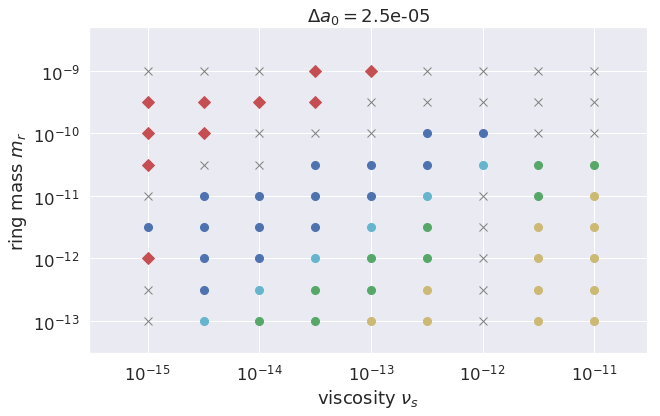

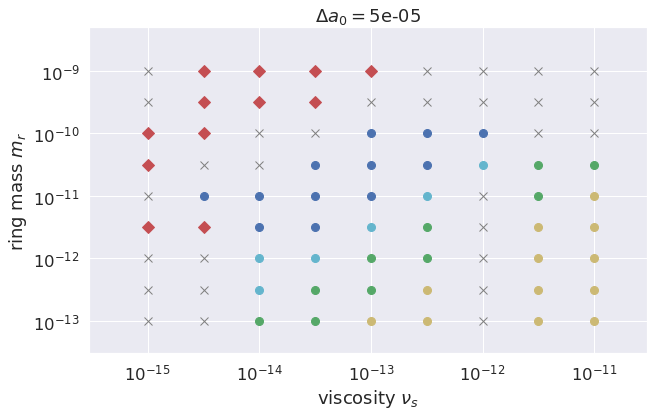

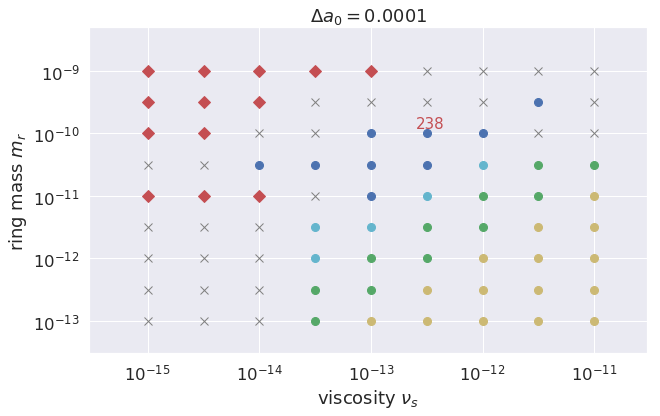

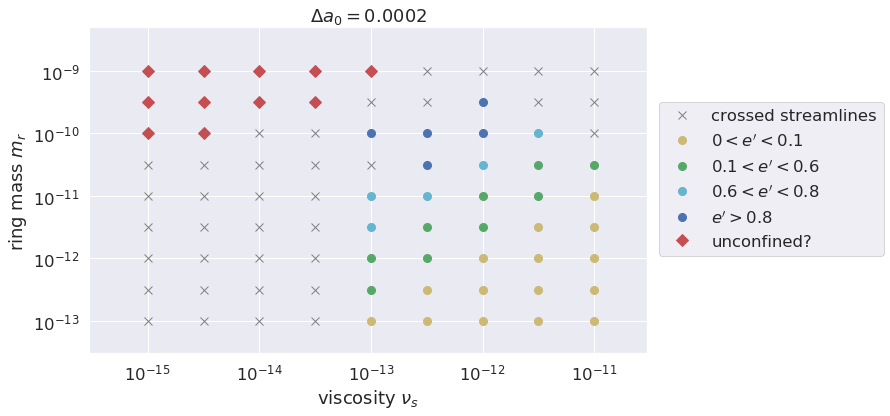

In [62]:
#show grid of simulation outcomes
df = df_results
radial_widths = np.sort(df.radial_width.unique())
e_prime_brackets = [(0.0, r"$0 < e'<0.1$", color_seq[8]),
                    (0.1, r"$0.1<e'<0.6$", color_seq[2]),
                    (0.6, r"$0.6<e'<0.8$", color_seq[9]),
                    (0.8, r"$e'>0.8$", color_seq[0])]
for radial_width in radial_widths:
    idx = (df.radial_width == radial_width)
    dfs = df[idx]
    sns.set(font_scale=1.5, font='DejaVu Sans')
    f, ax = plt.subplots(figsize=(10, 6))
    #x for sims that crossed streamlines
    idx = (dfs.outcome == 'crossed streamlines')
    dfss = dfs[idx]
    xp = dfss.shear_viscosity
    yp = dfss.total_ring_mass
    p = ax.plot(xp, yp, linestyle='none', marker='x', markersize=8, color='grey', label='crossed streamlines')
    #dot for self-confining sims
    idx = (dfs.outcome == 'self-confining')
    dfss = dfs[idx]
    for e_prime_bracket, label, color in e_prime_brackets:
        idx = (dfss.e_prime_bracket == e_prime_bracket)
        dfsss = dfss[idx]
        xp = dfsss.shear_viscosity
        yp = dfsss.total_ring_mass
        p = ax.plot(xp, yp, linestyle='none', marker='o', markersize=8, label=label, color=color)
    #diamond for simulation complete sims
    idx = (dfs.outcome == 'unconfined')
    dfss = dfs[idx]
    xp = dfss.shear_viscosity
    yp = dfss.total_ring_mass
    color = color_seq[3]
    p = ax.plot(xp, yp, linestyle='none', marker='D', markersize=8, color=color, label='unconfined?')
    #annotate the nominal sim_id
    idx = (dfs.nominal == True)
    if (idx.sum() > 0):
        dfss = dfs[idx]
        sim_id = str(dfss.sim_id.values[0])
        xp = dfss.shear_viscosity.values[0]
        yp = dfss.total_ring_mass.values[0]
        xy = (0.8*xp, 1.2*yp)
        color = color_seq[3]
        p = ax.annotate(sim_id, xy, fontsize=15, color=color)
    p = ax.set_xscale('log')
    p = ax.set_yscale('log')
    p = ax.set_xlabel(r'viscosity $\nu_s$')
    p = ax.set_ylabel(r'ring mass $m_r$')
    title = r'$\Delta a_0 = $' + str(radial_width)
    p = ax.set_title(title)
    p = ax.set_xlim(3.0e-16, 3.0e-11)
    p = ax.set_ylim(3.0e-14, 5.0e-9)
    if (radial_width == radial_widths[-1]):
        p = ax.legend(loc=(1.02, 0.3))
    file = 'figs/sim_grid_da_'+ str(radial_width) + '.pdf'
    print 'file = ', file
    plt.savefig(file, bbox_inches='tight')

In [63]:
#conda install scikit-learn
#conda install pyarrow

number of e_prime_bracket=0.8 sims =  42
number of sims plotted =  5


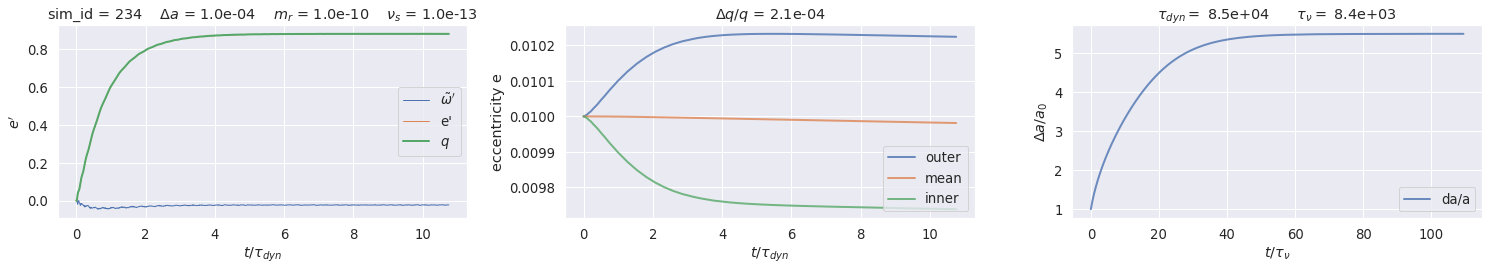

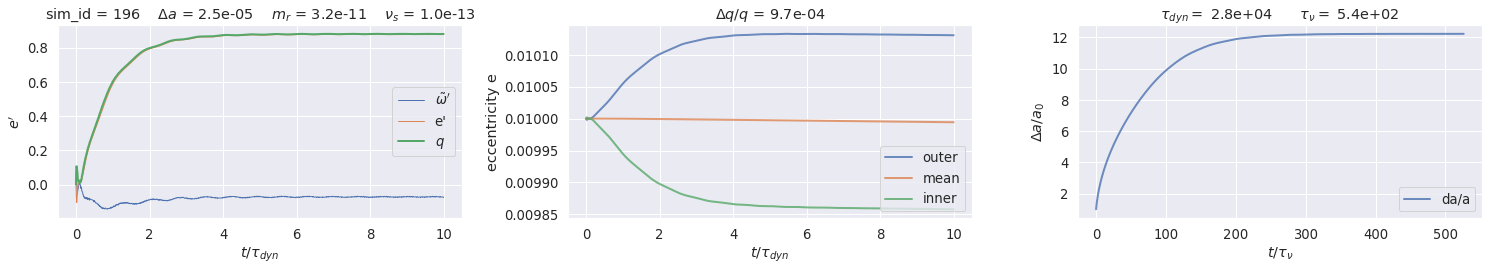

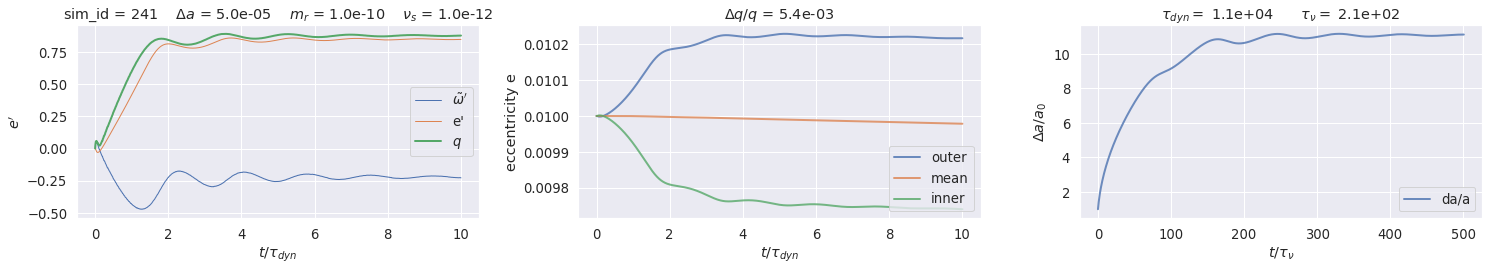

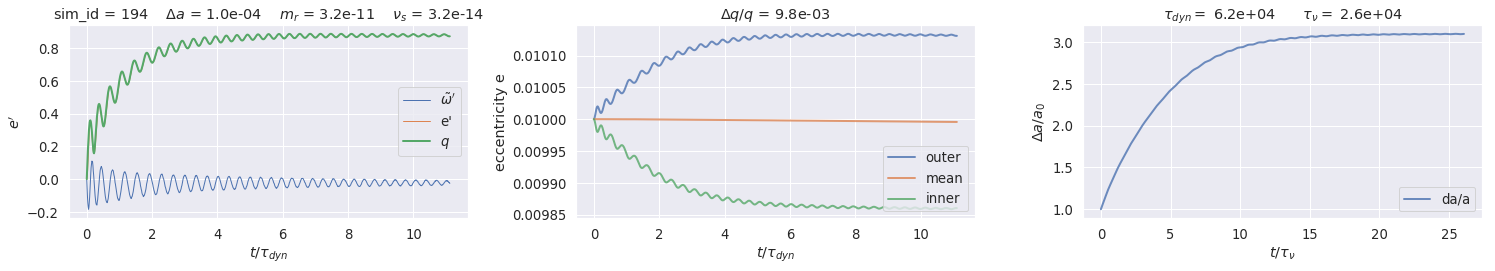

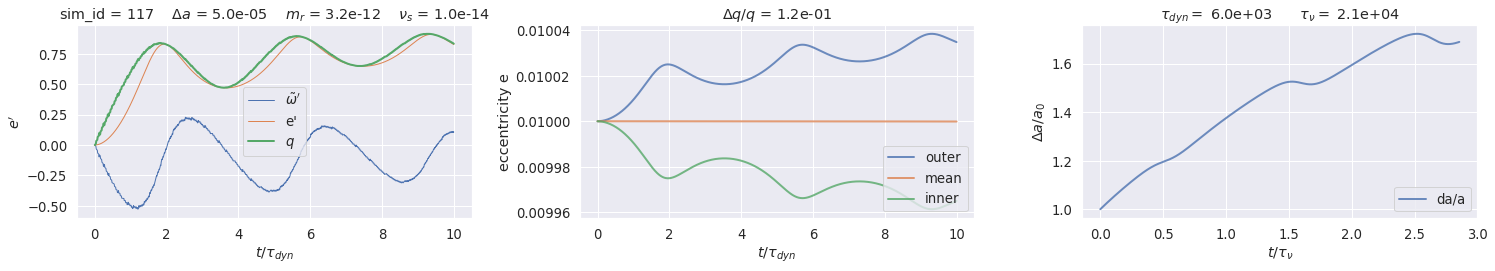

In [64]:
#generate summary plots for sample of e_prime_bracket=0.8 sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.8
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.8 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.6 sims =  22
number of sims plotted =  5


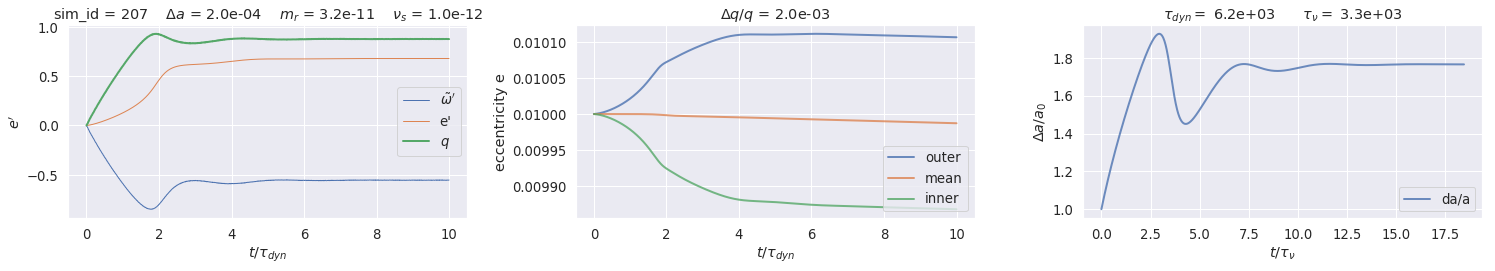

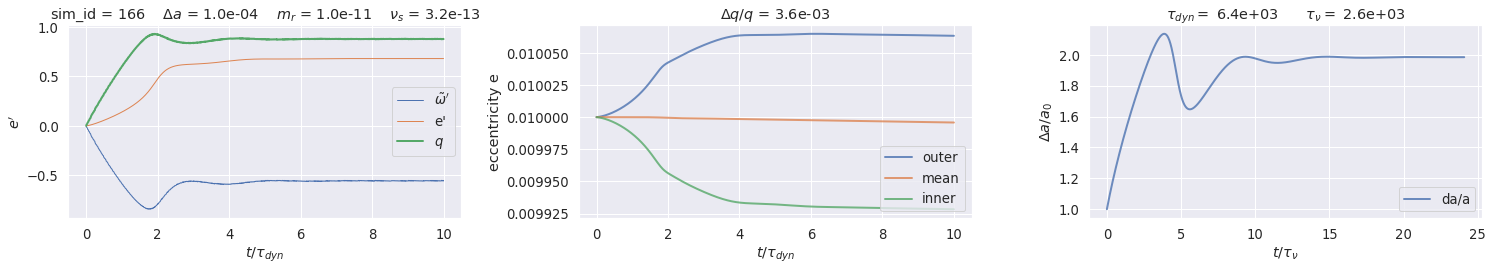

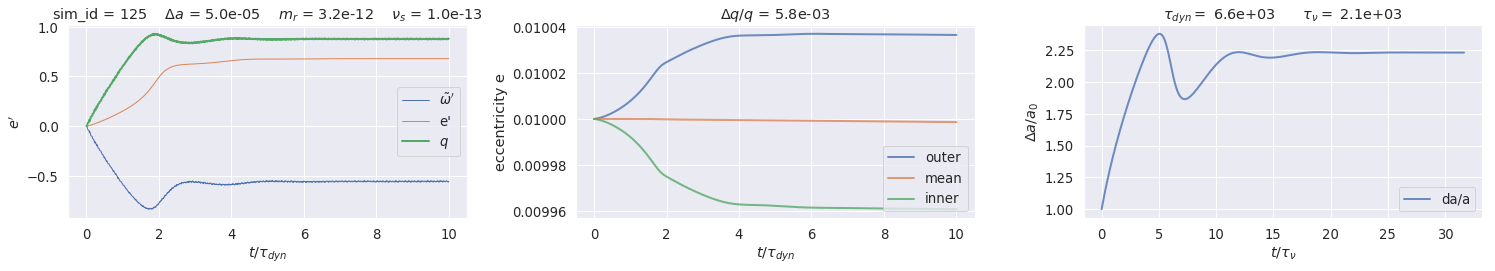

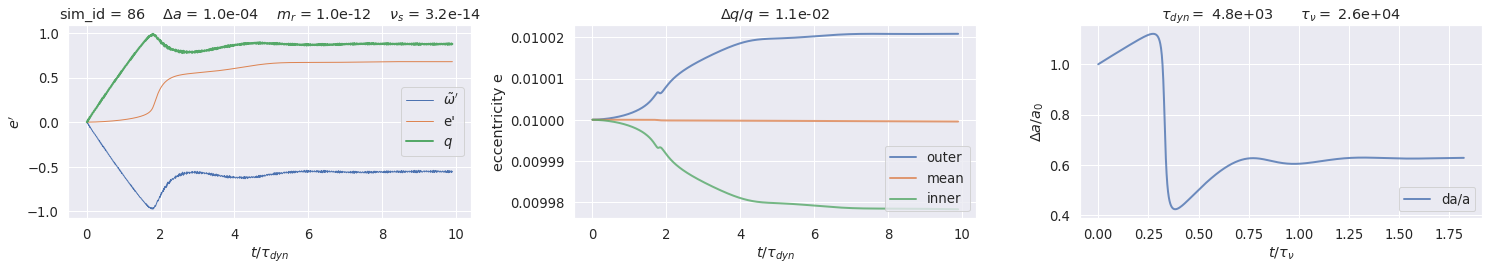

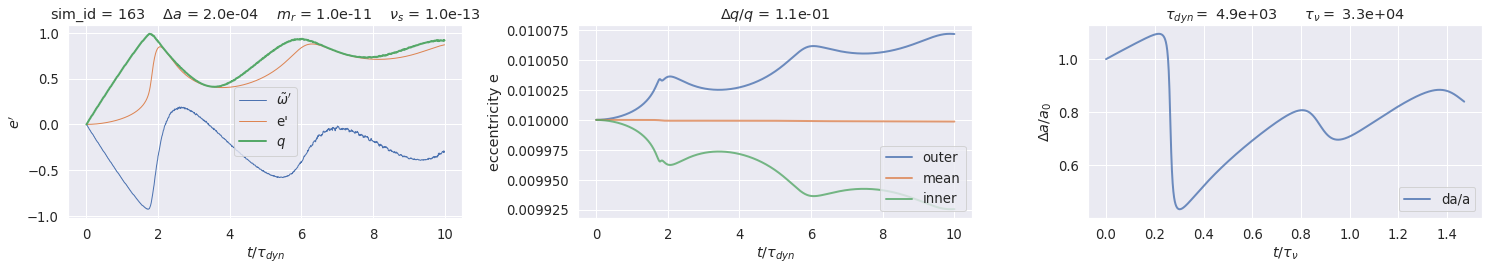

In [65]:
#generate summary plots for sample of e_prime_bracket=0.6 (ie 0.6<e'<0.8) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.6
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.6 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.1 sims =  40
number of sims plotted =  5


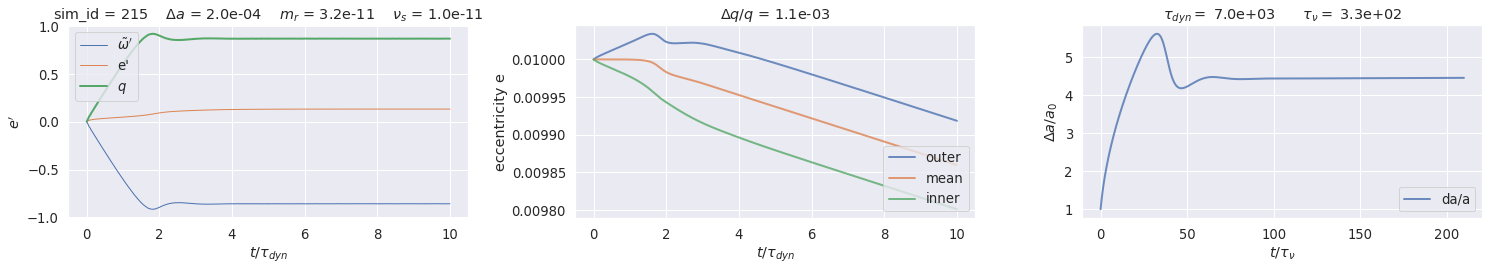

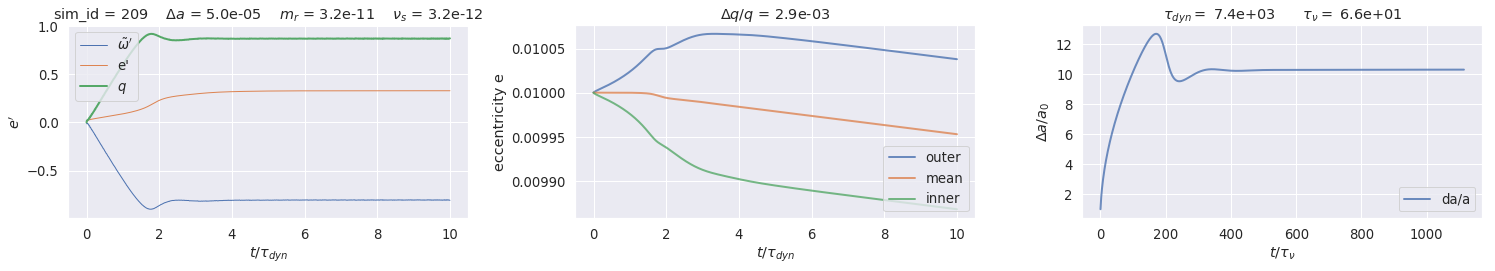

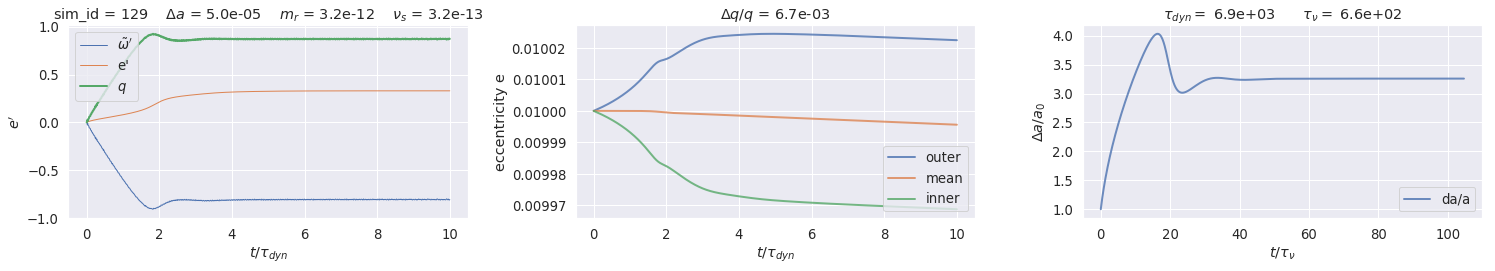

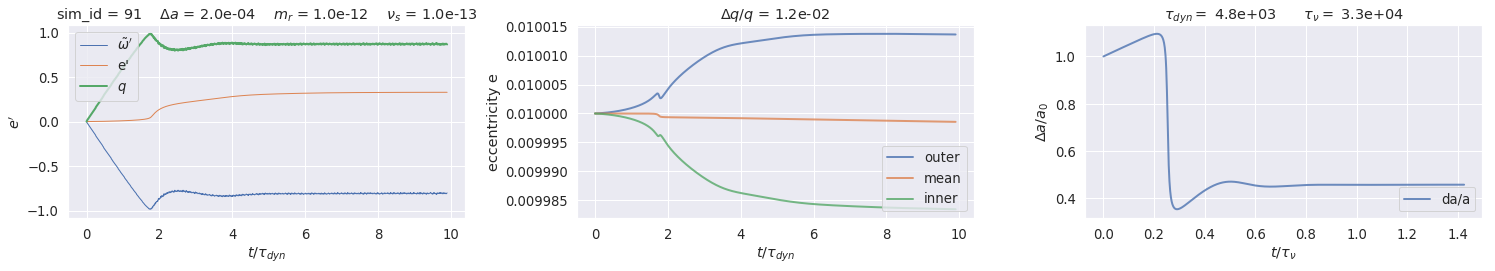

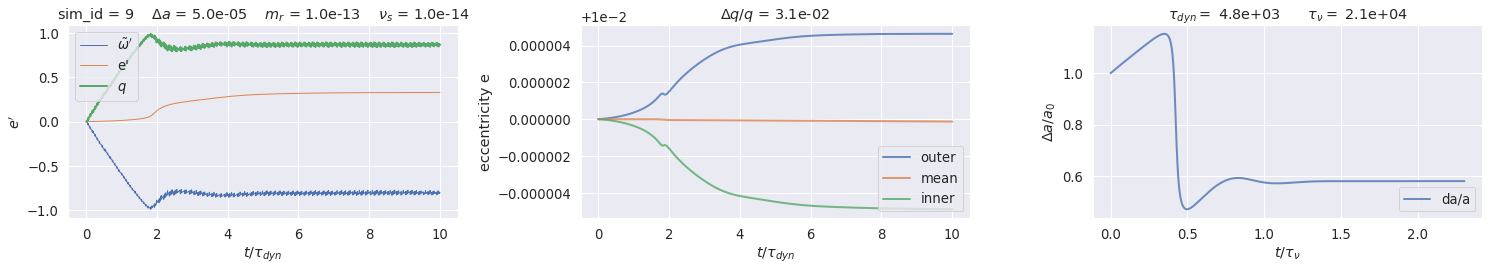

In [66]:
#generate summary plots for sample of e_prime_bracket=0.1 (ie 0.1<e'<0.6) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.1
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.1 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.0 sims =  54
number of sims plotted =  5


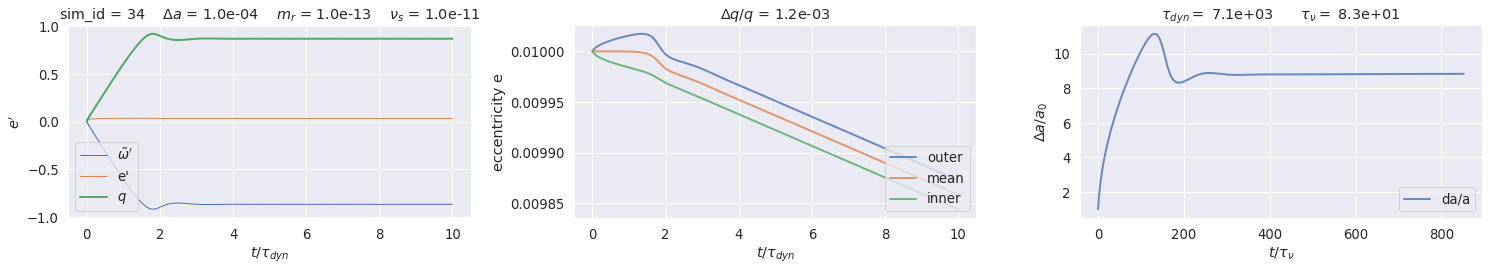

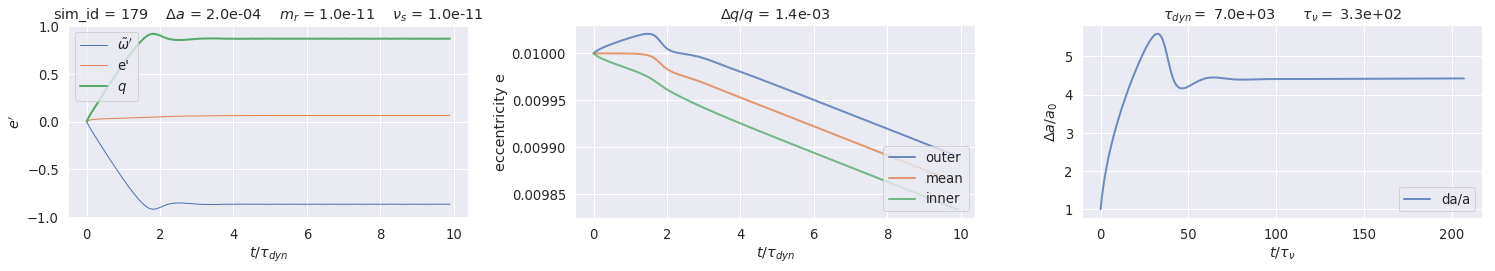

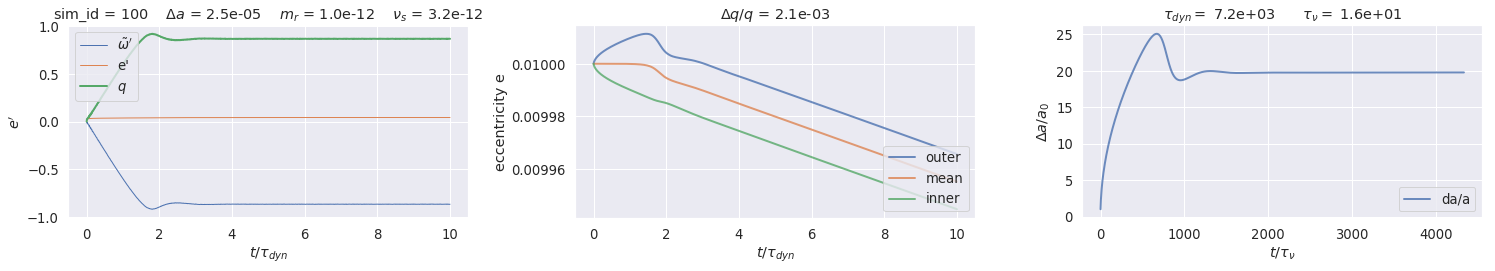

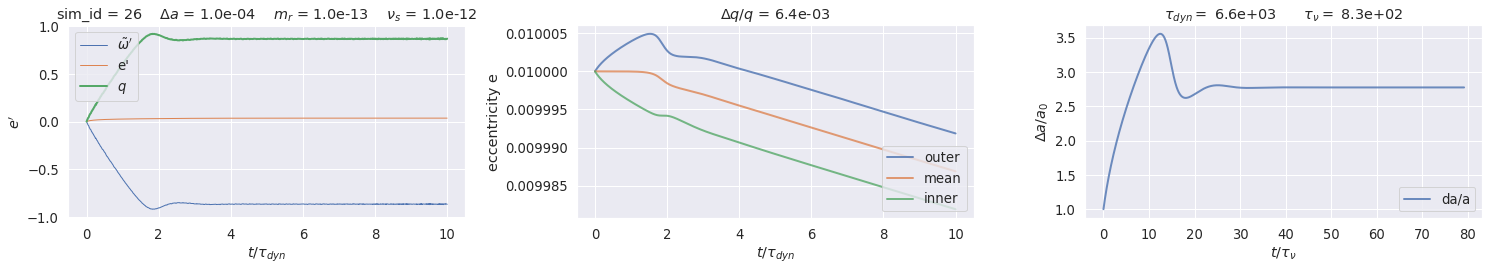

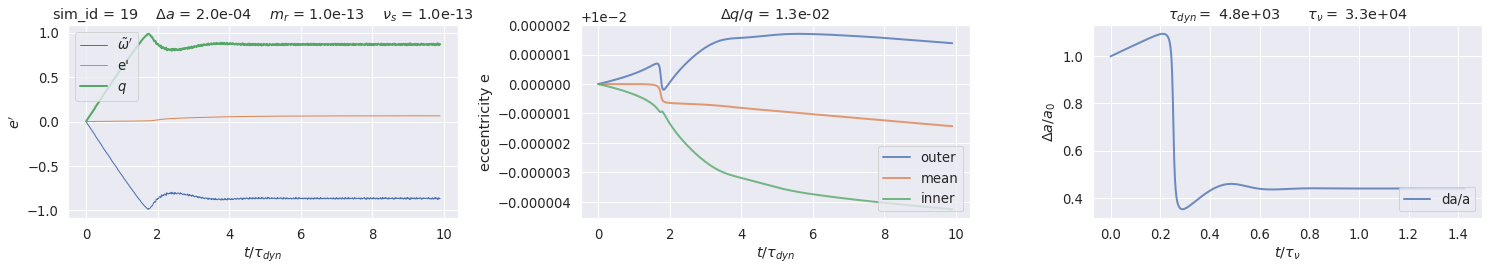

In [67]:
#generate summary plots for sample of e_prime_bracket=0.0 (ie 0.0<e'<0.1) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.0
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.0 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of unconfined sims =  46


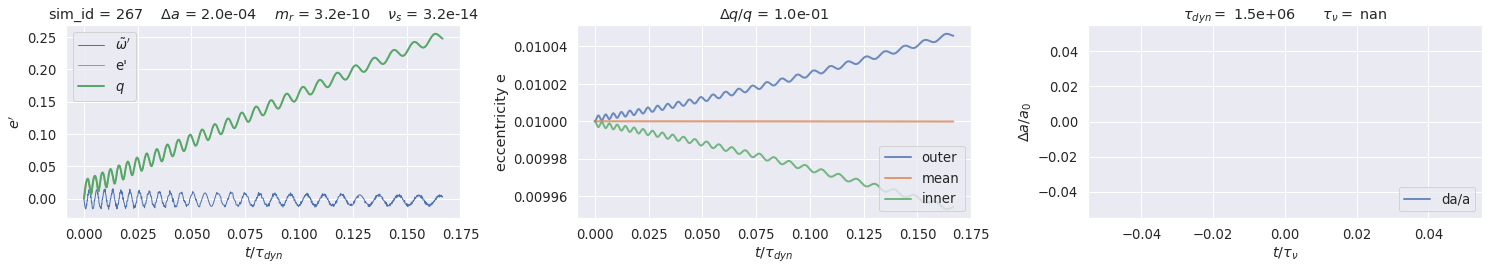

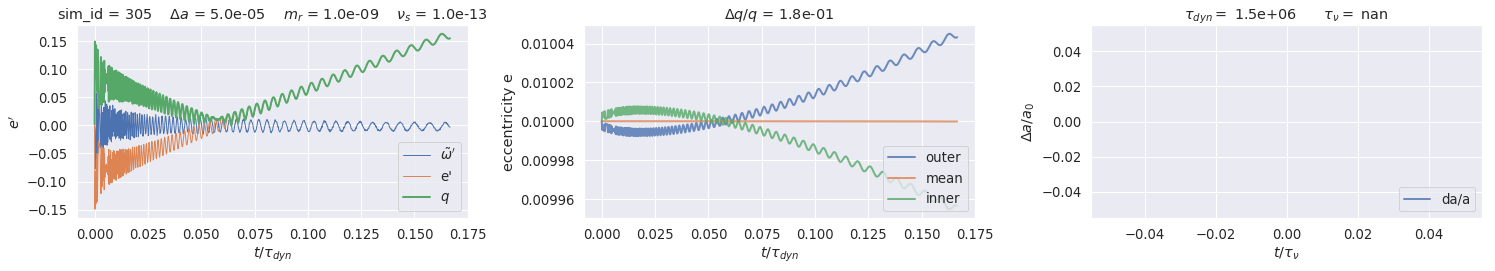

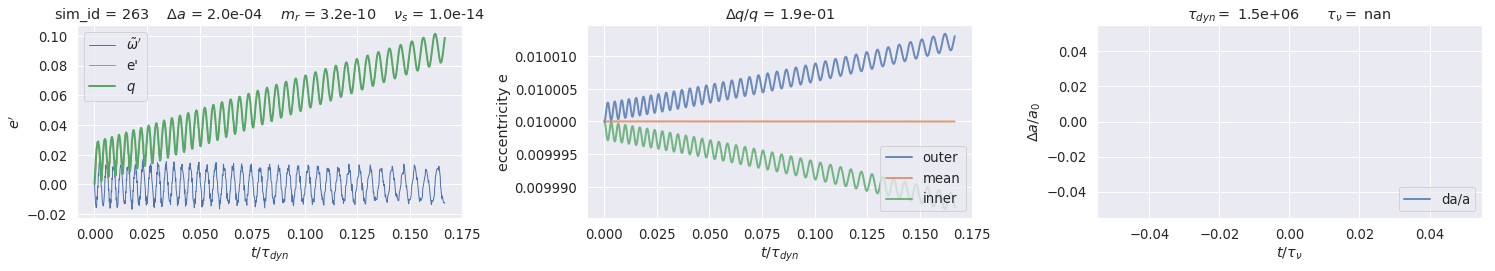

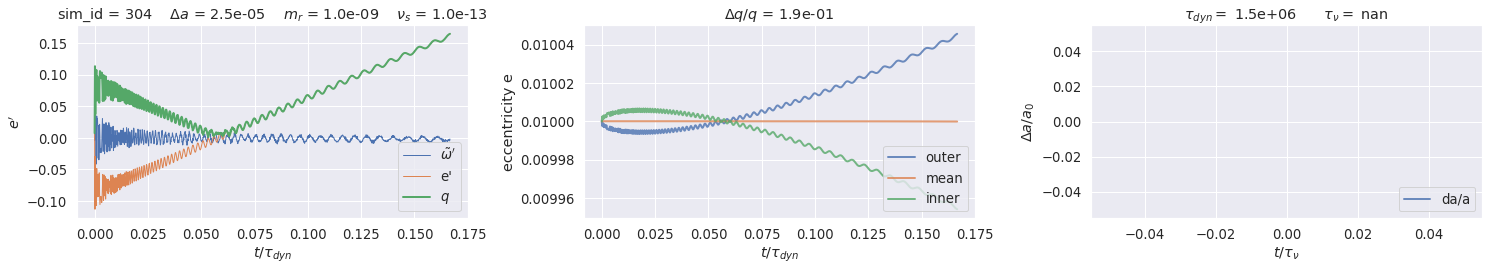

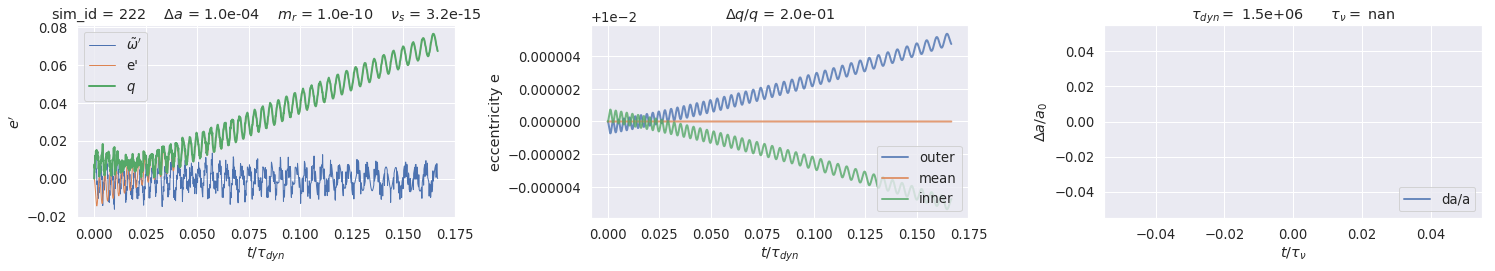

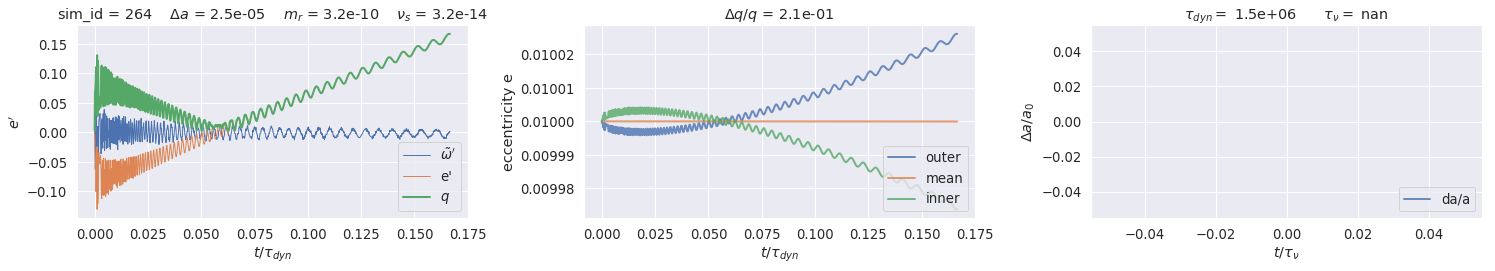

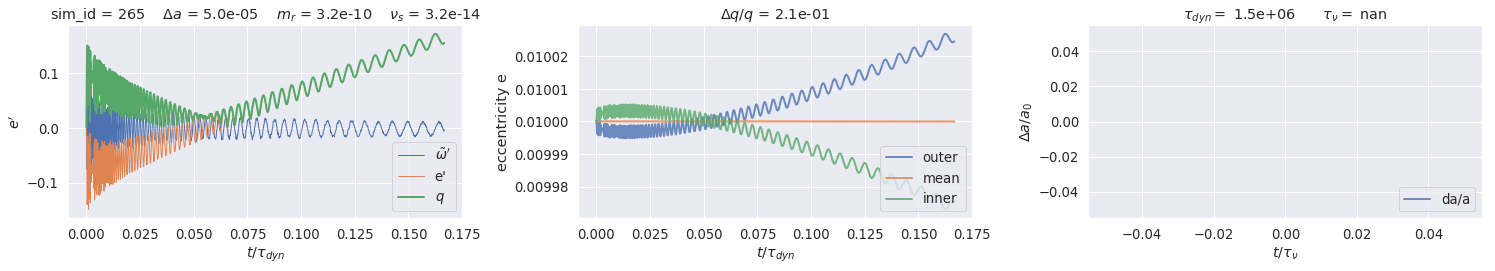

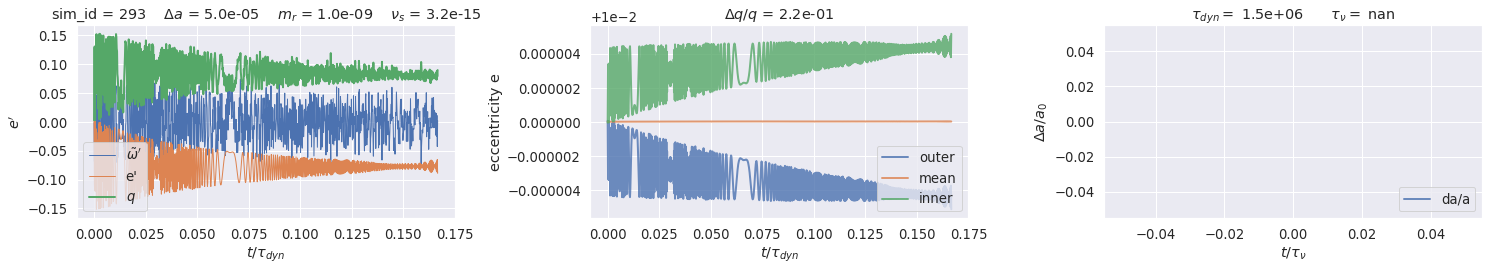

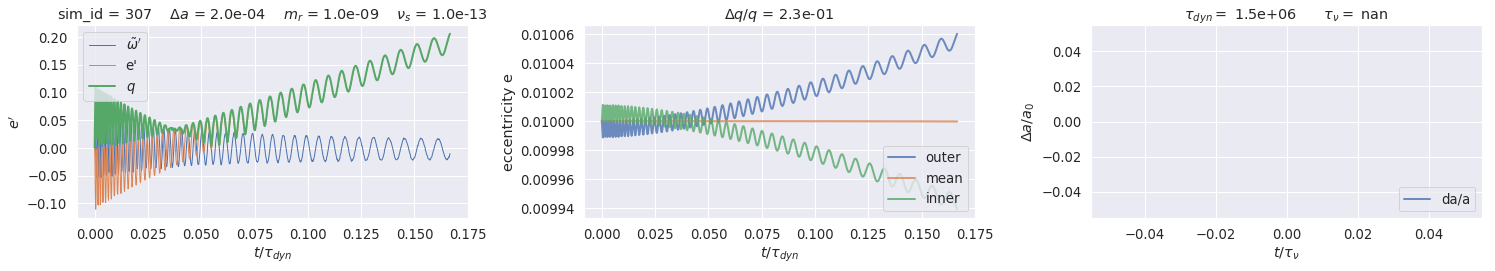

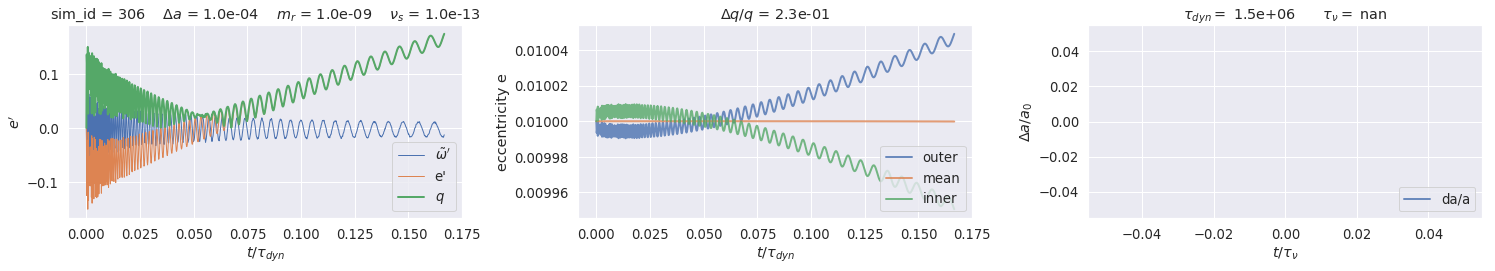

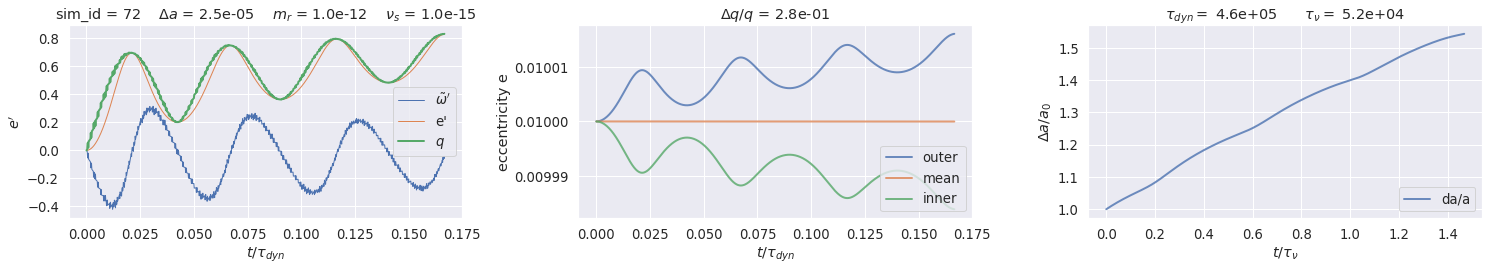

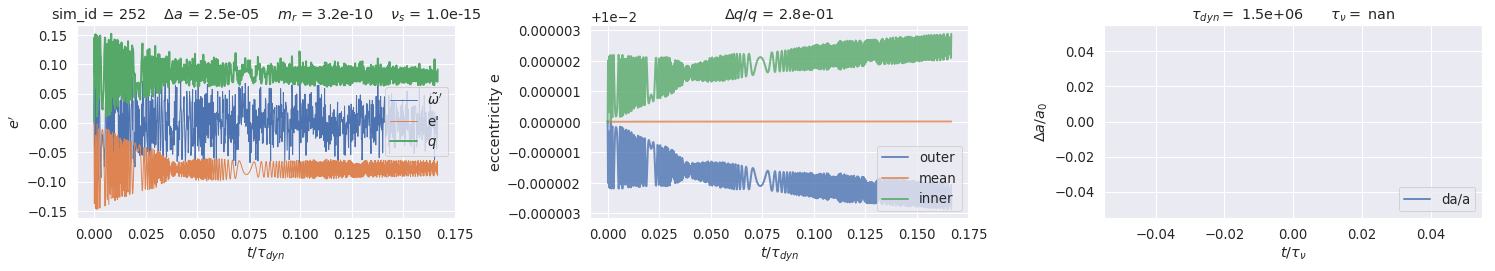

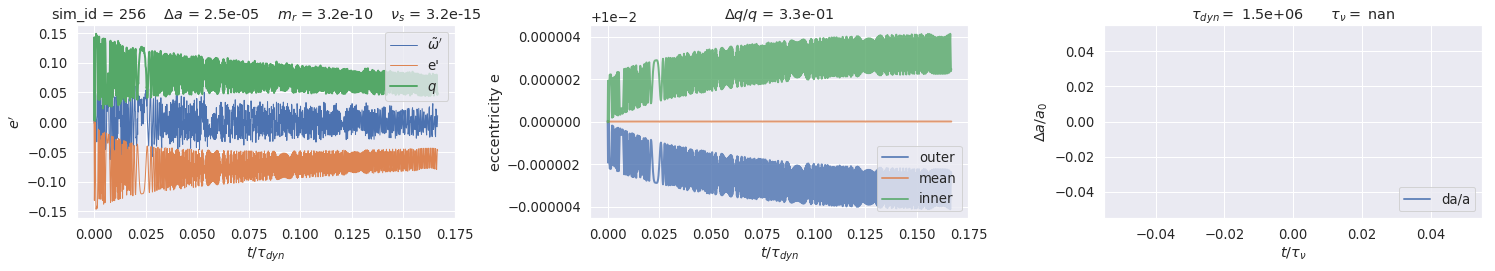

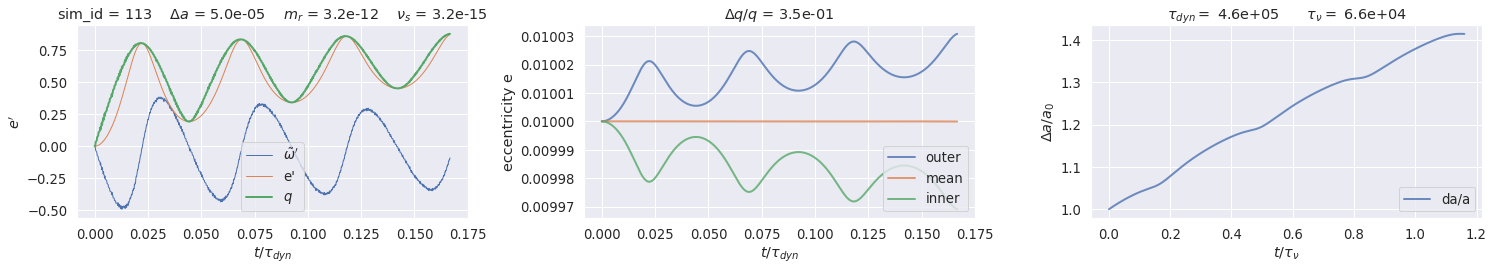

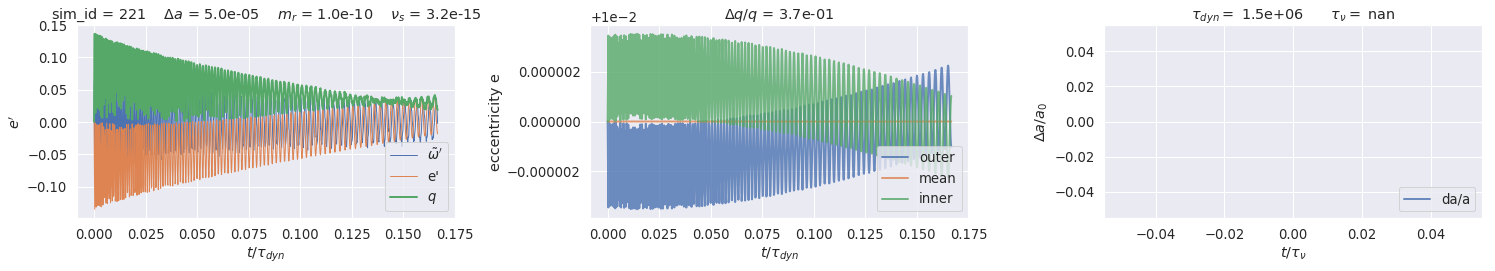

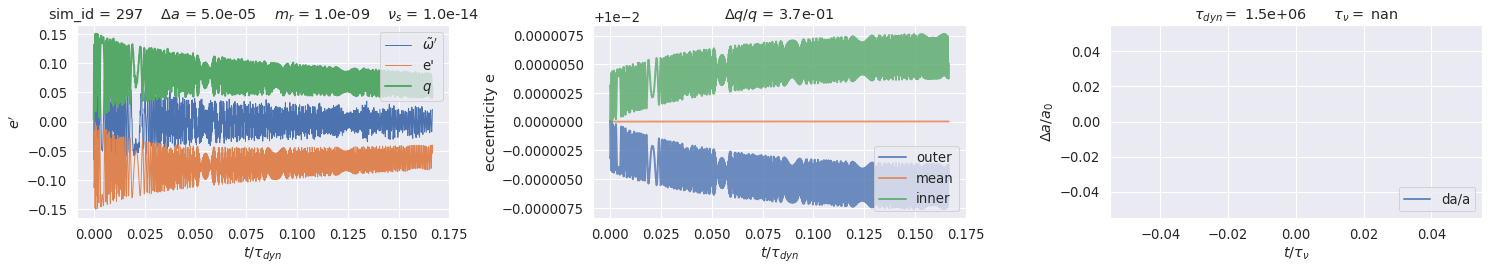

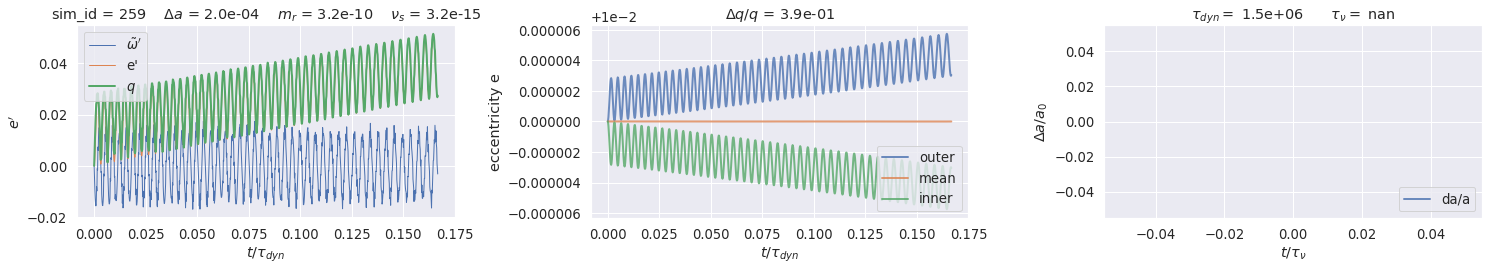

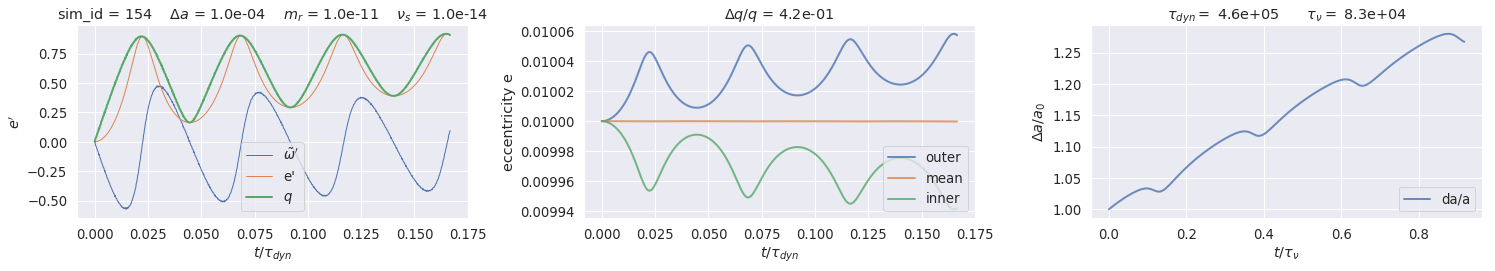

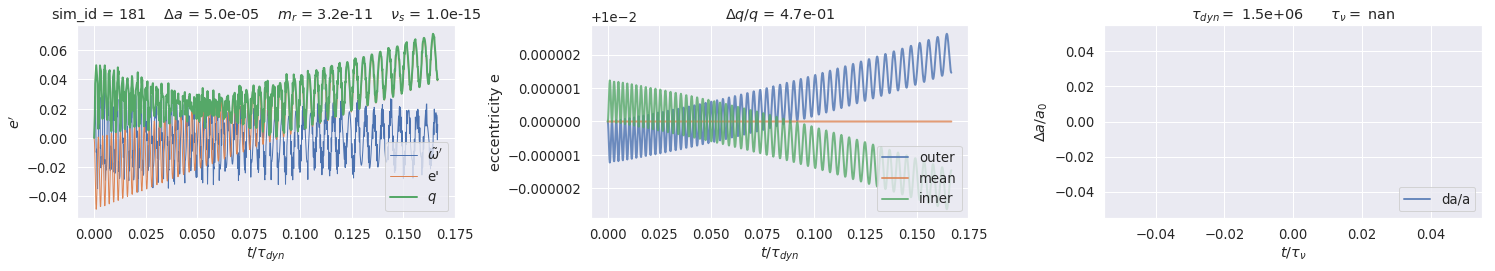

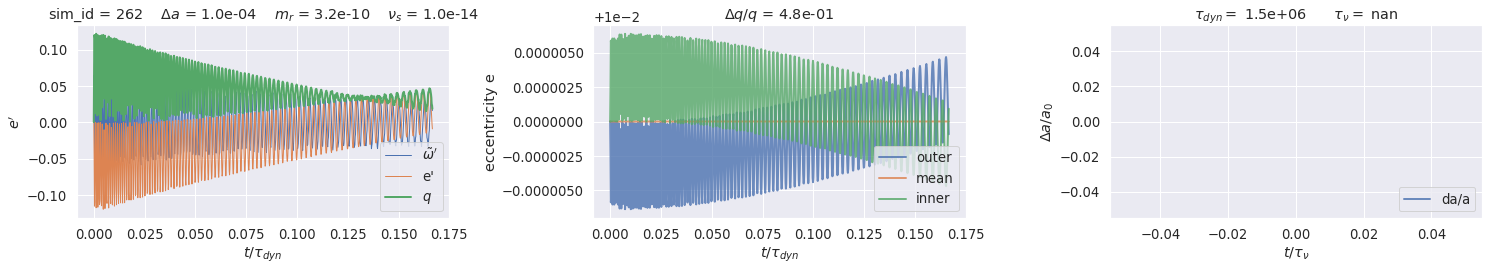

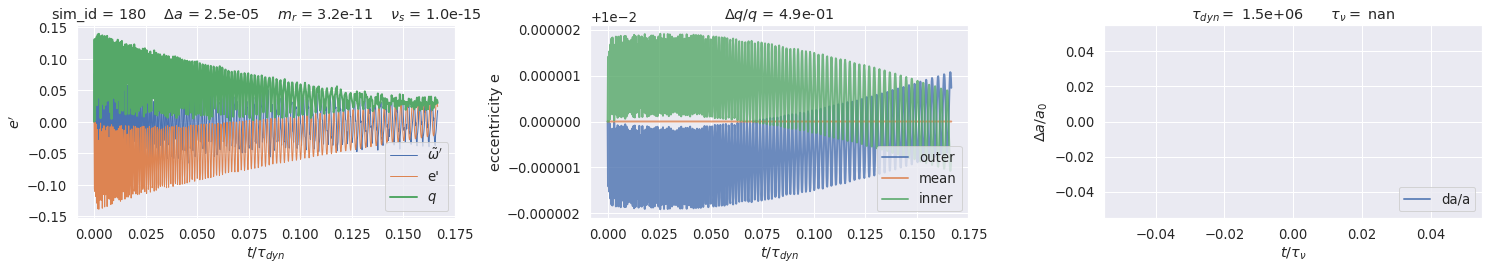

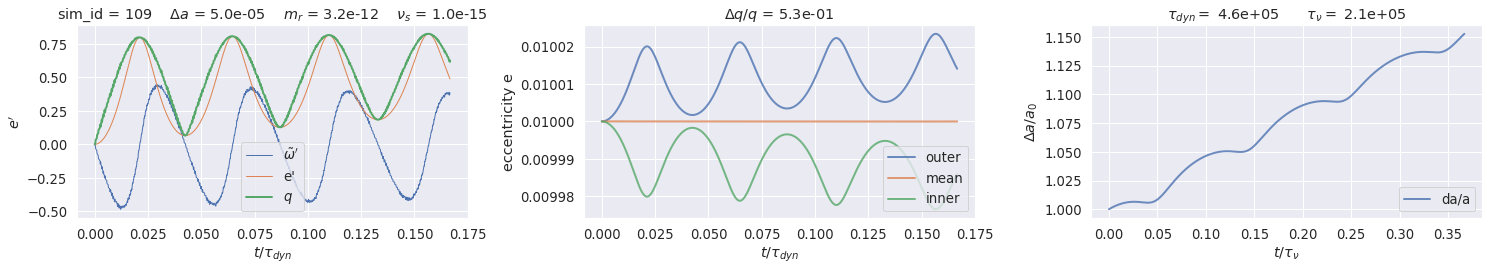

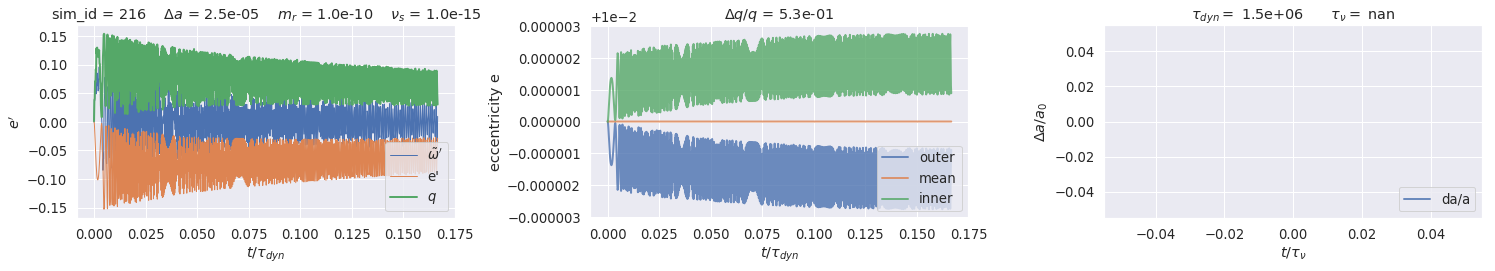

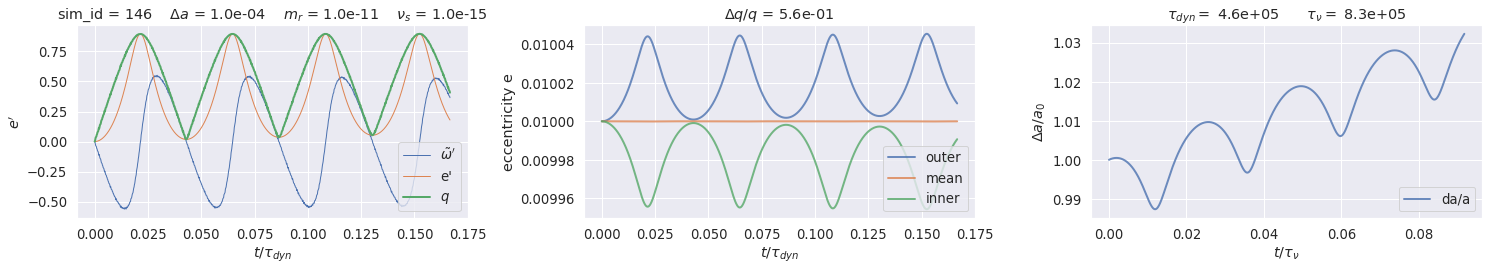

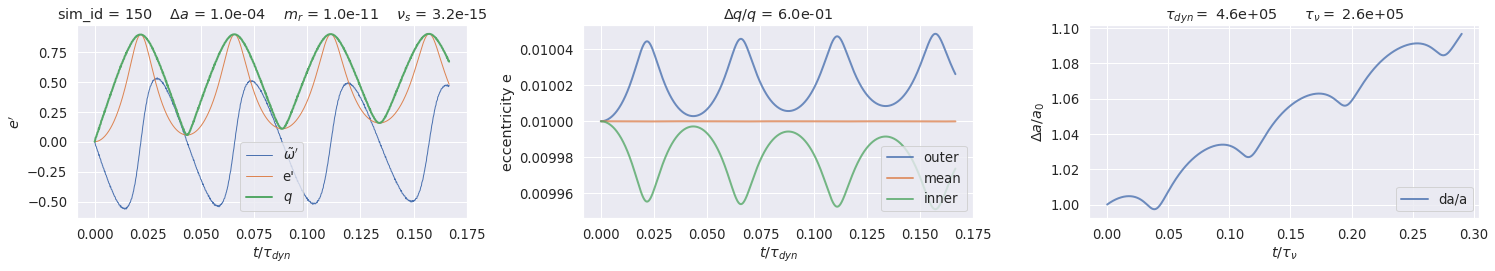

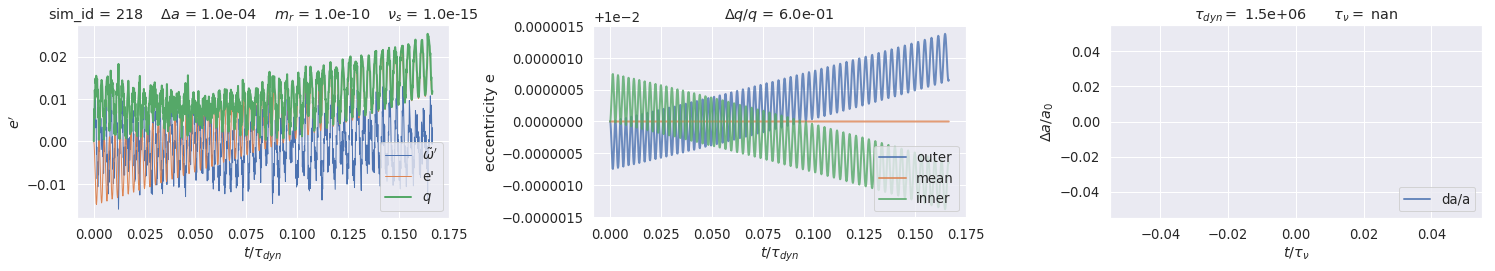

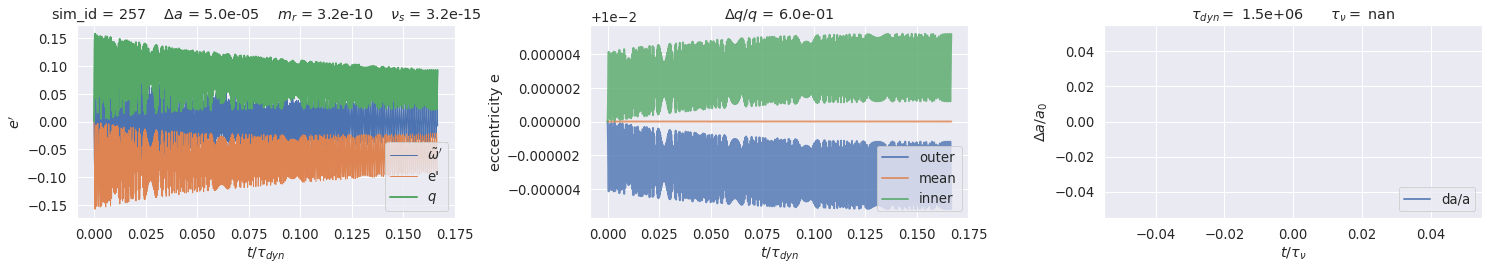

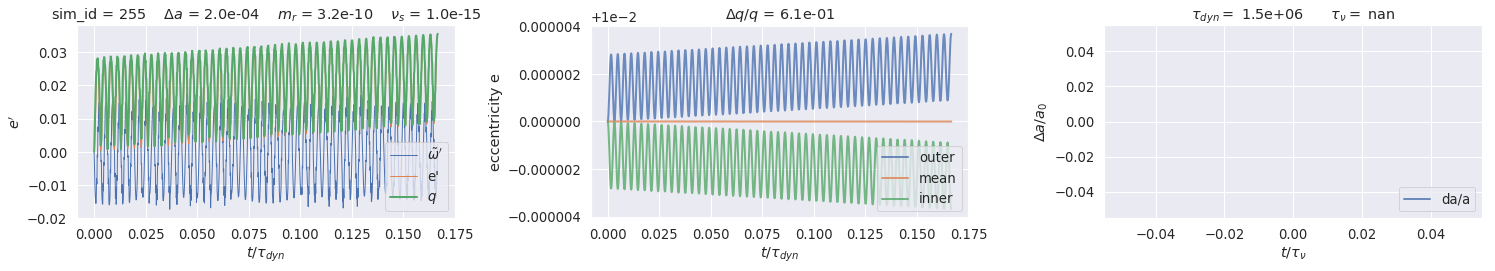

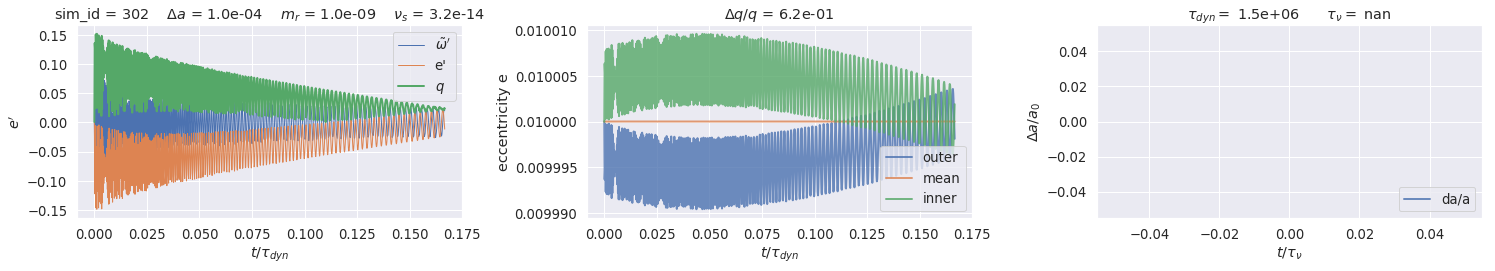

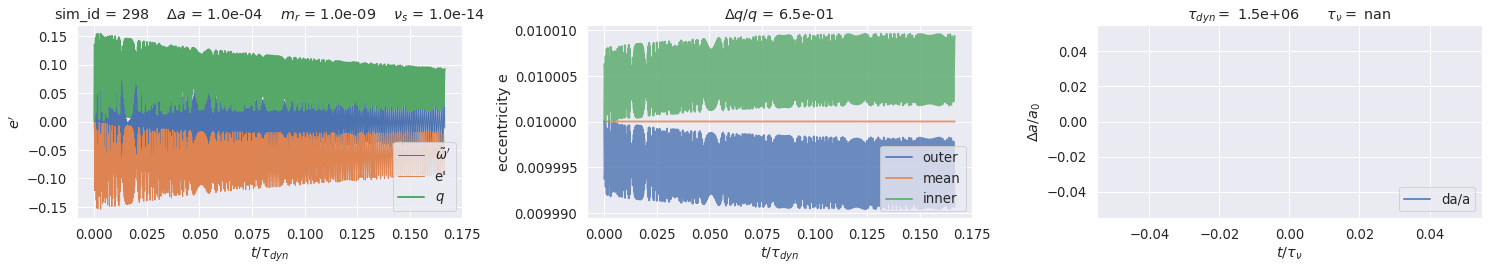

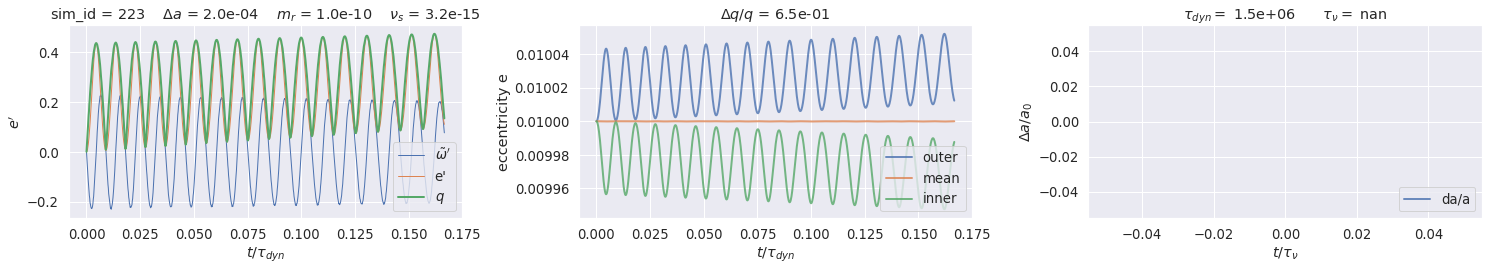

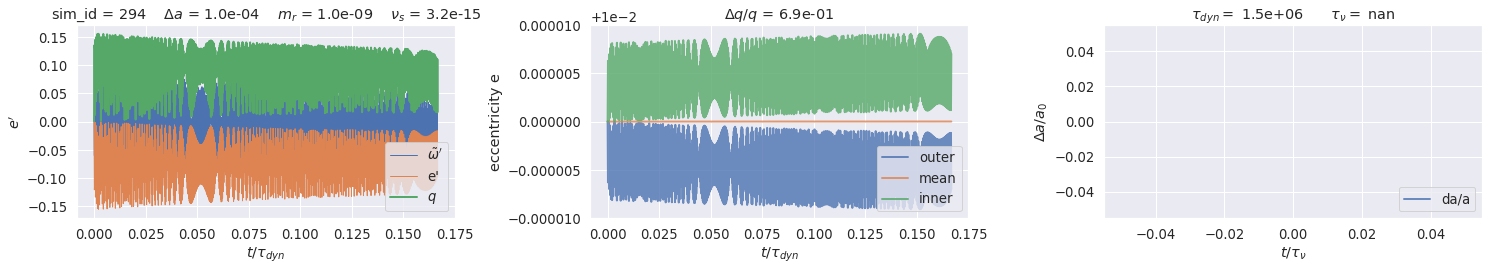

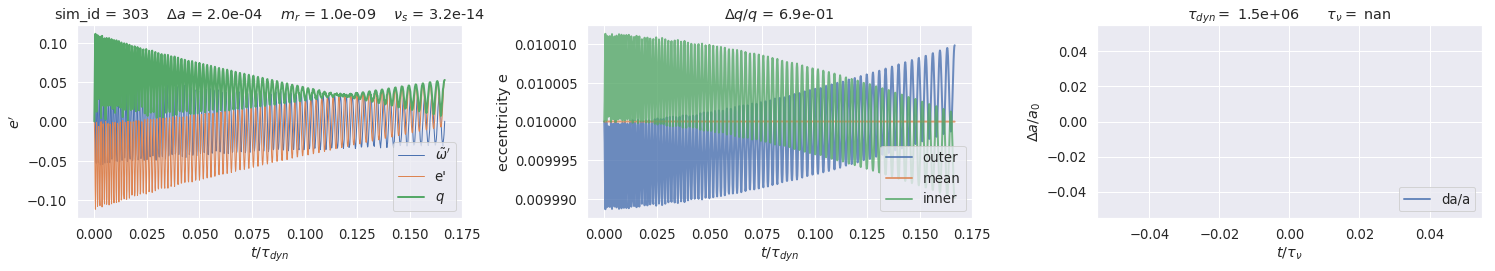

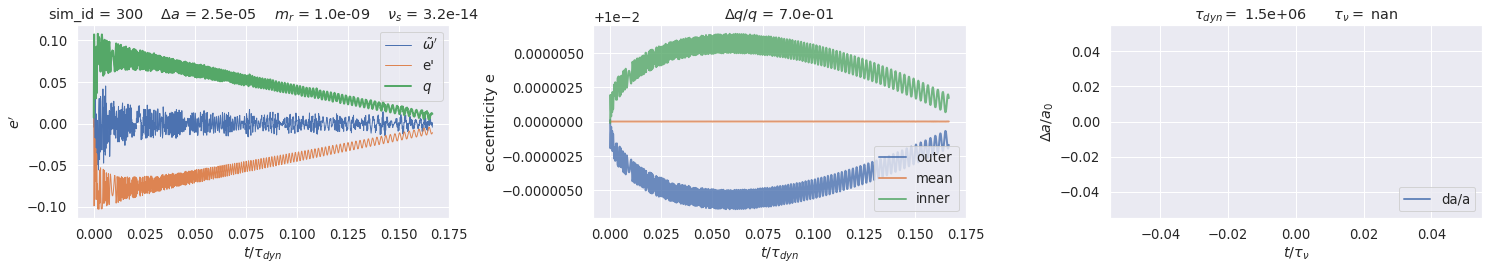

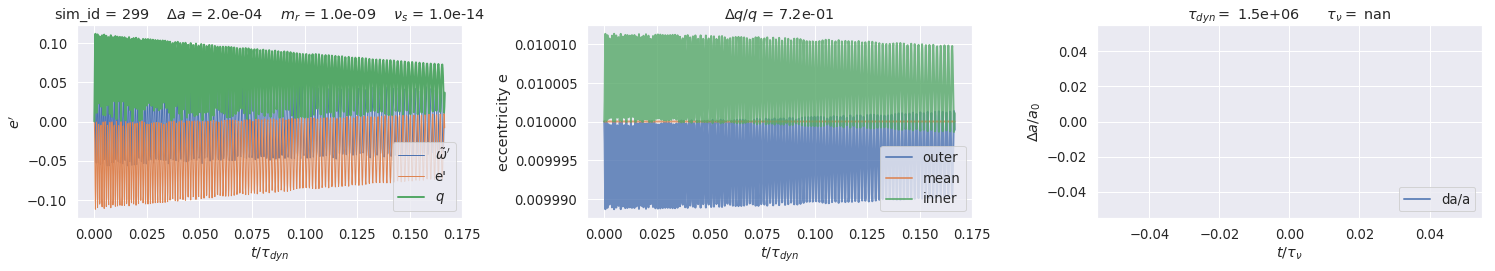

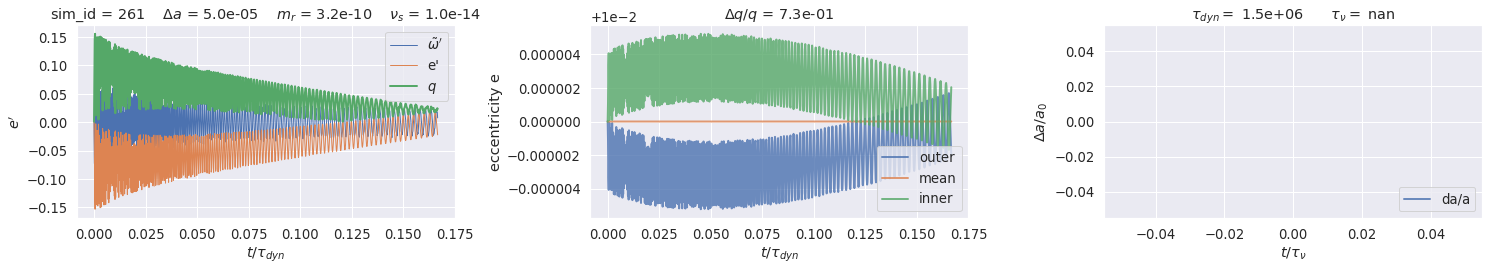

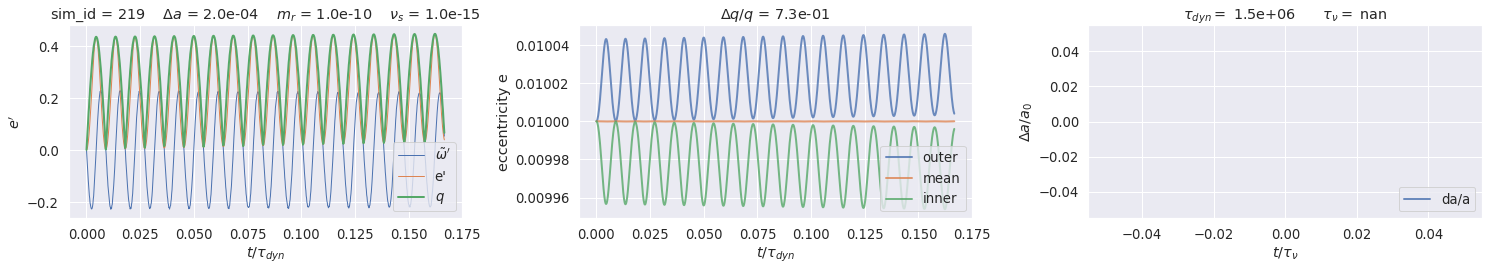

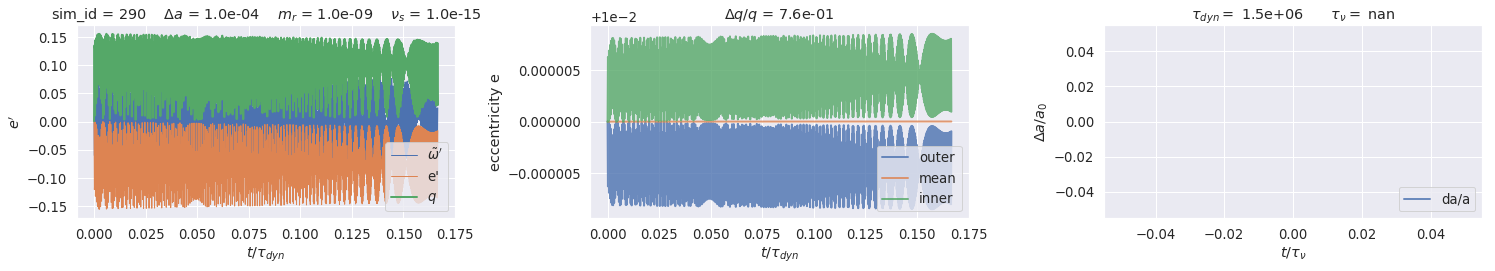

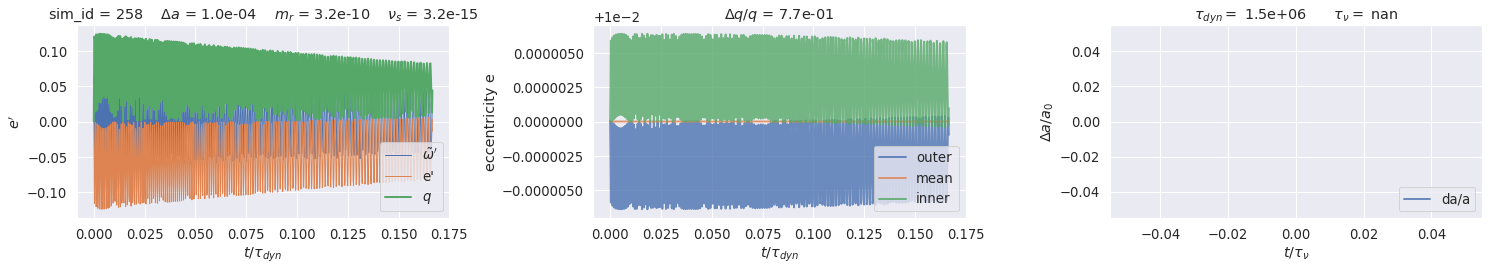

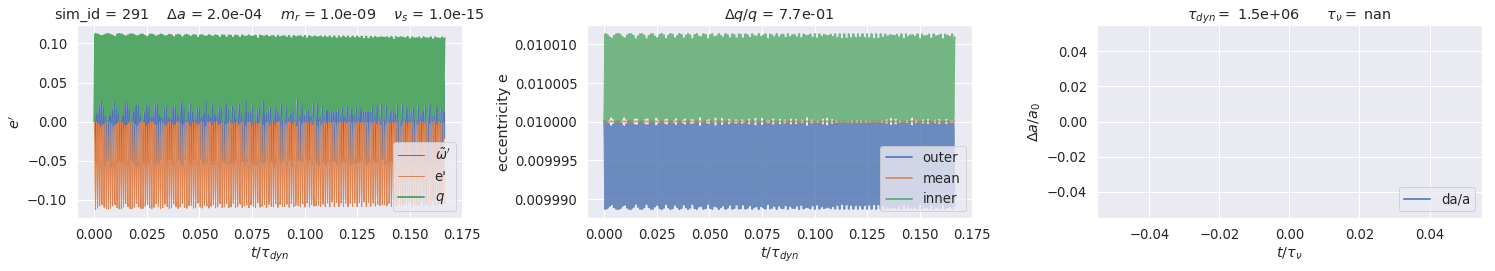

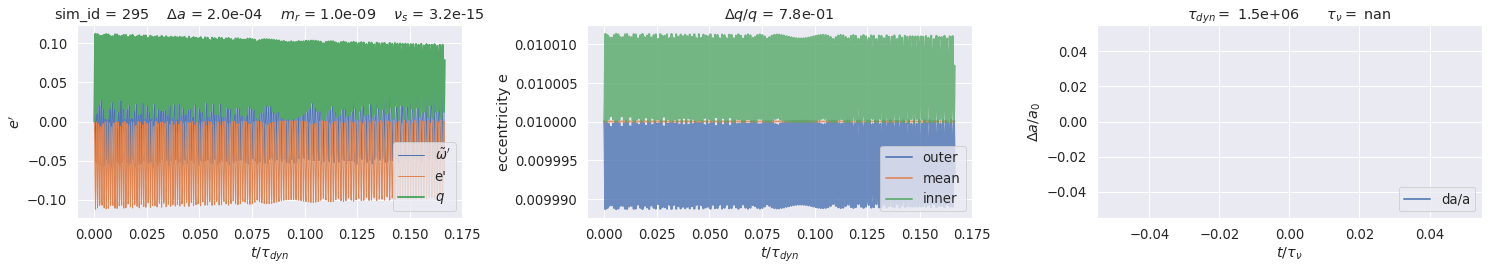

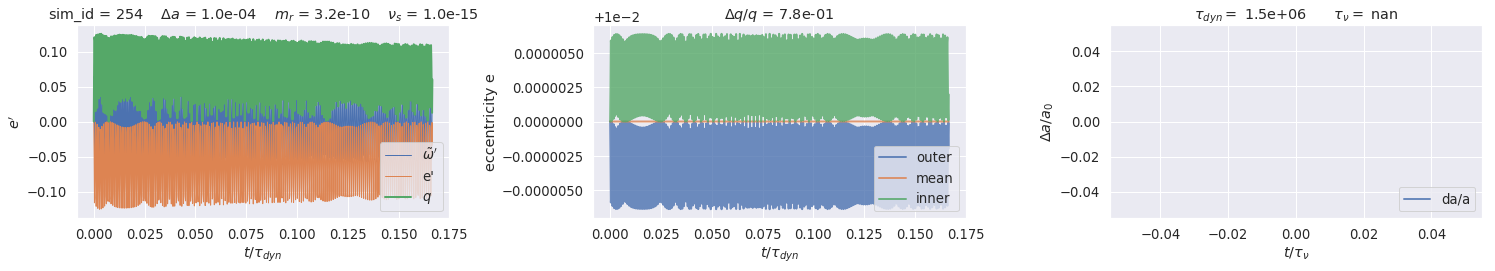

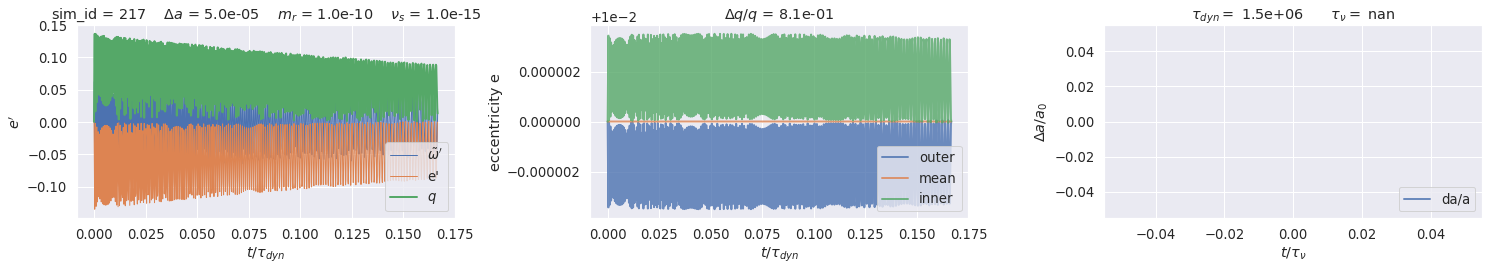

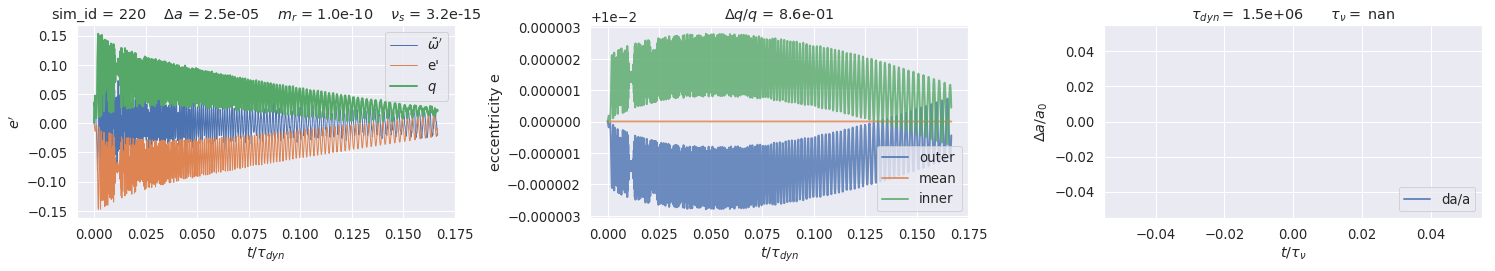

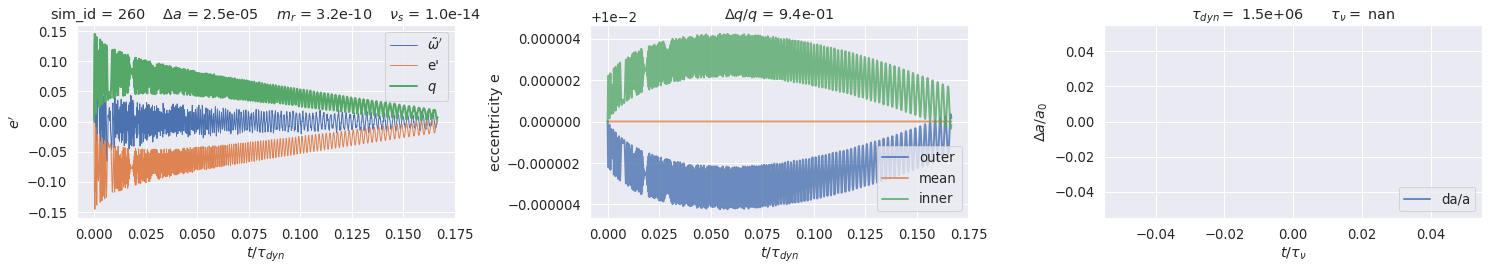

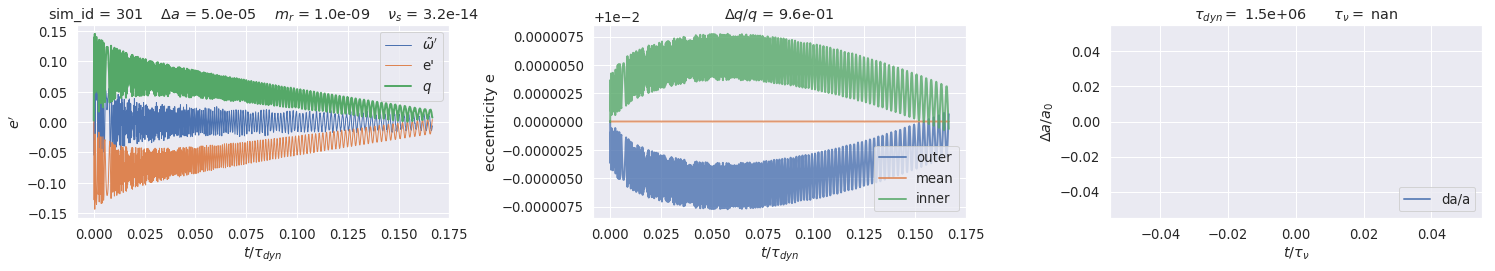

In [68]:
#generate summary plots for all unconfined sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
idx = (df.outcome == 'unconfined')
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of unconfined sims = ', len(dfs)
for idx, row in dfs.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

In [22]:
#done
time_exec_min = (tm.time() - t_start)/60
print 'time_exec_min = ', time_exec_min

time_exec_min =  0.901861313979
